In [26]:
import pandas as pd
import numpy as np
import io
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import mannwhitneyu, kruskal
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [2]:
print(plt.style.available)
plt.style.use('seaborn-v0_8')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
# 设置绘图样式和字体
plt.style.use('seaborn-v0_8')
sns.set_context("paper", font_scale=1.5)
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于显示中文标签
#plt.rcParams['axes.unicode_minus'] = False    # 用于正常显示负号

In [5]:
df = pd.read_csv("US_vote.csv")

In [ ]:
df.shape

(352, 7)

In [ ]:
# 查看数据基本信息
print(f"数据集维度: {df.shape}")
print("\n前5行数据:")
print(df.head())

数据集维度: (352, 7)

前5行数据:
     state candidate_name  ecvotes_actual  votes_actual  ecwin_actual  \
0  Alabama      Write-ins               9      0.314724         False   
1  Alabama   Donald Trump               9     62.030970          True   
2  Alabama   Jo Jorgensen               9      1.083629         False   
3  Alabama      Joe Biden               9     36.570677         False   
4   Alaska      Write-ins               3      8.741625         False   

   Unnamed: 5  Unnamed: 6  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN  


In [6]:
df_both = df[df['candidate_name'].isin(['Joe Biden', 'Donald Trump'])]
df_both = df_both[['state', 'candidate_name', 'ecvotes_actual', 'votes_actual', 'ecwin_actual']]
df_both = df_both.dropna()

In [11]:
# 查看清理后的数据
print("\n清理后数据示例:")
print(df_both.head())

# 基本描述统计
desc_stats = df_both.groupby('candidate_name')['votes_actual'].describe()
print("\n按候选人分组的得票率描述统计:")
print(desc_stats)

# 计算各候选人的获胜州数量
win_counts = df_both.groupby('candidate_name')['ecwin_actual'].sum()
print("\n各候选人获胜州数:")
print(win_counts)

# 计算各候选人的票数
result = (
    df_both[df_both['ecwin_actual']]  # 筛选第五列为True的行
    .groupby('candidate_name')  # 按第二列分组
    .apply(lambda group: group['ecvotes_actual'].sum())  # 计算第三列的和
)
print(result)


清理后数据示例:
      state candidate_name  ecvotes_actual  votes_actual  ecwin_actual
1   Alabama   Donald Trump               9     62.030970          True
3   Alabama      Joe Biden               9     36.570677         False
7    Alaska   Donald Trump               3     48.522791          True
10   Alaska      Joe Biden               3     39.199327         False
13  Arizona   Donald Trump              11     49.055981         False

按候选人分组的得票率描述统计:
                count       mean        std        min        25%        50%  \
candidate_name                                                                 
Donald Trump     51.0  49.094728  11.992487   5.397321  40.814401  49.055981   
Joe Biden        51.0  48.577554  12.116719  26.553574  39.525392  49.364691   

                      75%        max  
candidate_name                        
Donald Trump    57.835234  69.936228  
Joe Biden       56.800293  92.149694  

各候选人获胜州数:
candidate_name
Donald Trump    25
Joe Biden       26
Name: 

/tmp/ipython-input-3815507701.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group['ecvotes_actual'].sum())  # 计算第三列的和


In [14]:
gdp_data = pd.read_csv("bea-gdp-by-state.csv")
df_wide = df_both.pivot(index='state', columns='candidate_name', values='votes_actual').reset_index()
df_wide.columns.name = None
df_wide = df_wide.merge(gdp_data[['state', '2020']], left_on='state', right_on='state', how='left')
df_wide = df_wide.rename(columns={'2020': 'gdp_per_capita'})
df_wide['vote_margin'] = df_wide['Joe Biden'] - df_wide['Donald Trump']

print(f"数据集包含 {len(df_wide)} 个州/地区")
print("\n基本统计描述:")
print(df_wide[['Joe Biden', 'Donald Trump', 'vote_margin', 'gdp_per_capita']].describe())

数据集包含 51 个州/地区

基本统计描述:
       Joe Biden  Donald Trump  vote_margin  gdp_per_capita
count  51.000000     51.000000    51.000000       51.000000
mean   48.577554     49.094728    -0.517174    77651.861373
std    12.116719     11.992487    24.057650    29606.302007
min    26.553574      5.397321   -43.382653    39448.000000
25%    39.525392     40.814401   -17.568436    64475.500000
50%    49.364691     49.055981     0.235688    73047.000000
75%    56.800293     57.835234    15.985892    83225.000000
max    92.149694     69.936228    86.752373   259938.000000


In [21]:
def comprehensive_parametric_assumption_testing(biden_votes, trump_votes):
    """
    系统检验参数统计的基本假设
    参考第4章：假设检验的理论基础
    """
    print("="*70)
    print("参数统计假设的全面诊断分析")
    print("="*70)

    results = {}

    # 1. 正态性假设的多重检验
    print("\n【1. 正态性假设检验】")
    print("-" * 50)

    # Shapiro-Wilk检验（小样本最优）
    biden_sw = stats.shapiro(biden_votes)
    trump_sw = stats.shapiro(trump_votes)

    # Anderson-Darling检验（对尾部更敏感）
    biden_ad = stats.anderson(biden_votes, dist='norm')
    trump_ad = stats.anderson(trump_votes, dist='norm')

    # Kolmogorov-Smirnov检验
    biden_ks = stats.kstest(biden_votes, 'norm',
                           args=(np.mean(biden_votes), np.std(biden_votes)))
    trump_ks = stats.kstest(trump_votes, 'norm',
                           args=(np.mean(trump_votes), np.std(trump_votes)))

    print(f"Biden得票率正态性检验:")
    print(f"  Shapiro-Wilk: W={biden_sw.statistic:.4f}, p={biden_sw.pvalue:.6f}")
    print(f"  Anderson-Darling: A2={biden_ad.statistic:.4f}, 临界值(5%)={biden_ad.critical_values[2]:.4f}")
    print(f"  Kolmogorov-Smirnov: D={biden_ks.statistic:.4f}, p={biden_ks.pvalue:.6f}")

    print(f"\nTrump得票率正态性检验:")
    print(f"  Shapiro-Wilk: W={trump_sw.statistic:.4f}, p={trump_sw.pvalue:.6f}")
    print(f"  Anderson-Darling: A2={trump_ad.statistic:.4f}, 临界值(5%)={trump_ad.critical_values[2]:.4f}")
    print(f"  Kolmogorov-Smirnov: D={trump_ks.statistic:.4f}, p={trump_ks.pvalue:.6f}")

    # 2. 分布形态特征分析
    print(f"\n【2. 分布形态诊断】")
    print("-" * 50)

    biden_skew, biden_skew_pval = stats.skewtest(biden_votes)
    biden_kurt, biden_kurt_pval = stats.kurtosistest(biden_votes)
    trump_skew, trump_skew_pval = stats.skewtest(trump_votes)
    trump_kurt, trump_kurt_pval = stats.kurtosistest(trump_votes)

    print(f"Biden: 偏度={biden_skew:.4f}(p={biden_skew_pval:.4f}), 峰度={biden_kurt:.4f}(p={biden_kurt_pval:.4f})")
    print(f"Trump: 偏度={trump_skew:.4f}(p={trump_skew_pval:.4f}), 峰度={trump_kurt:.4f}(p={trump_kurt_pval:.4f})")

    # 3. 方差齐性检验
    print(f"\n【3. 方差齐性假设检验】")
    print("-" * 50)

    levene_stat, levene_p = stats.levene(biden_votes, trump_votes)
    bartlett_stat, bartlett_p = stats.bartlett(biden_votes, trump_votes)
    fligner_stat, fligner_p = stats.fligner(biden_votes, trump_votes)

    print(f"Levene检验: F={levene_stat:.4f}, p={levene_p:.6f}")
    print(f"Bartlett检验: χ²={bartlett_stat:.4f}, p={bartlett_p:.6f}")
    print(f"Fligner-Killeen检验: χ²={fligner_stat:.4f}, p={fligner_p:.6f}")

    # 4. 独立性假设的理论分析
    print(f"\n【4. 独立性假设的挑战】")
    print("-" * 50)
    print("选举数据违反独立性假设的理论依据:")
    print("• 空间邻接效应：相邻州选民行为的相似性")
    print("• 媒体市场重叠：跨州信息传播的影响")
    print("• 人口流动性：州际人口迁移带来的政治观念传播")
    print("• 经济一体化：区域经济联系导致的政策偏好趋同")

    # 5. 综合诊断结论
    print(f"\n【5. 参数假设失效性总结】")
    print("-" * 50)

    normality_violations = [
        biden_sw.pvalue < 0.05, trump_sw.pvalue < 0.05,
        biden_ad.statistic > biden_ad.critical_values[2],
        trump_ad.statistic > trump_ad.critical_values[2]
    ]

    homogeneity_violations = [levene_p < 0.05, bartlett_p < 0.05, fligner_p < 0.05]

    print(f"正态性假设违反程度: {sum(normality_violations)}/4 项检验拒绝")
    print(f"方差齐性假设违反程度: {sum(homogeneity_violations)}/3 项检验拒绝")
    print(f"独立性假设: 基于理论分析，明确违反")

    if sum(normality_violations) >= 2 or sum(homogeneity_violations) >= 2:
        print(f"\n 结论：参数统计的核心假设系统性失效！")
        print(f"   推荐采用非参数统计方法进行分析")
        return True
    else:
        print(f"\n✅ 参数方法假设基本满足，但仍建议非参数分析作为稳健性检验")
        return False

# 执行假设检验
biden_votes = df_wide['Joe Biden'].values
trump_votes = df_wide['Donald Trump'].values
assumption_failed = comprehensive_parametric_assumption_testing(biden_votes, trump_votes)


参数统计假设的全面诊断分析

【1. 正态性假设检验】
--------------------------------------------------
Biden得票率正态性检验:
  Shapiro-Wilk: W=0.9525, p=0.039951
  Anderson-Darling: A2=0.3689, 临界值(5%)=0.7360
  Kolmogorov-Smirnov: D=0.0975, p=0.681280

Trump得票率正态性检验:
  Shapiro-Wilk: W=0.9496, p=0.030357
  Anderson-Darling: A2=0.3710, 临界值(5%)=0.7360
  Kolmogorov-Smirnov: D=0.0774, p=0.896763

【2. 分布形态诊断】
--------------------------------------------------
Biden: 偏度=2.2984(p=0.0215), 峰度=2.1056(p=0.0352)
Trump: 偏度=-2.4515(p=0.0142), 峰度=2.2331(p=0.0255)

【3. 方差齐性假设检验】
--------------------------------------------------
Levene检验: F=0.0188, p=0.891135
Bartlett检验: χ²=0.0053, p=0.942195
Fligner-Killeen检验: χ²=0.0151, p=0.902149

【4. 独立性假设的挑战】
--------------------------------------------------
选举数据违反独立性假设的理论依据:
• 空间邻接效应：相邻州选民行为的相似性
• 媒体市场重叠：跨州信息传播的影响
• 人口流动性：州际人口迁移带来的政治观念传播
• 经济一体化：区域经济联系导致的政策偏好趋同

【5. 参数假设失效性总结】
--------------------------------------------------
正态性假设违反程度: 2/4 项检验拒绝
方差齐性假设违反程度: 0/3 项检验拒绝
独立性假设: 基于理论分析，明确违反

 结论


Biden 核密度估计带宽比较:
交叉验证最优带宽: 7.8476
Scott's rule: 5.7926
Silverman's rule: 5.7884
Sheather-Jones近似: 4.9183

Trump 核密度估计带宽比较:
交叉验证最优带宽: 7.8476
Scott's rule: 5.7333
Silverman's rule: 5.7291
Sheather-Jones近似: 4.8679


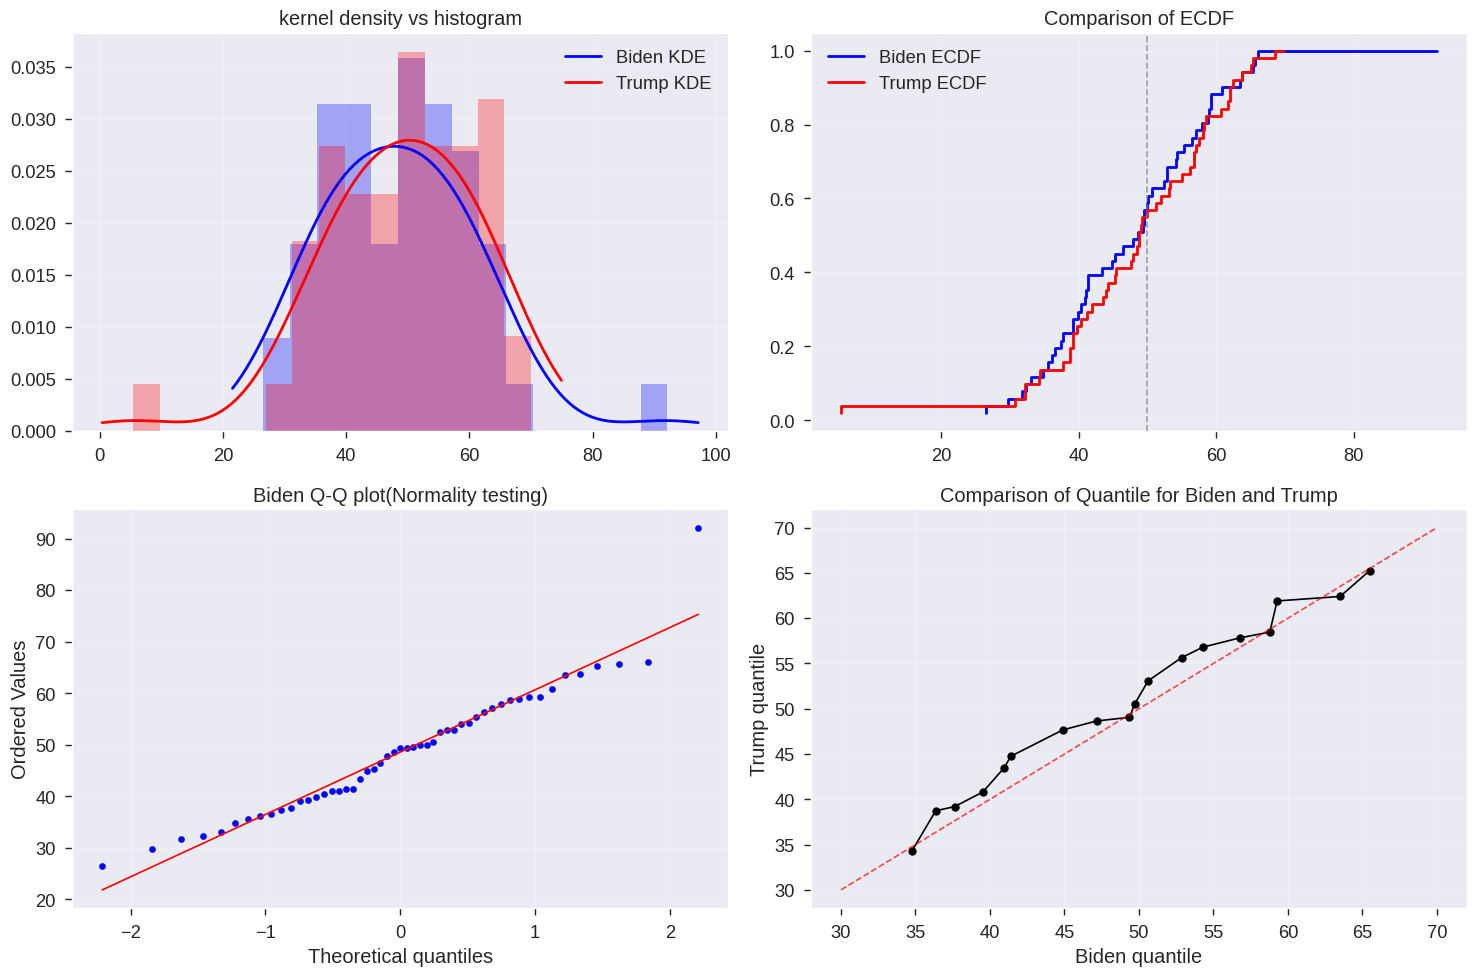

In [32]:
#### 9.1.3.2 高级核密度估计与带宽优化
def advanced_kde_analysis(data, candidate_name):
    """
    高级核密度估计分析
    参考第3章：非参数估计和计算技术
    """
    # 1. 最优带宽选择：交叉验证方法
    bandwidths = np.logspace(-1, 1, 20)
    kde_cv = GridSearchCV(KernelDensity(kernel='gaussian'),
                         {'bandwidth': bandwidths}, cv=5)
    kde_cv.fit(data.reshape(-1, 1))
    optimal_bw = kde_cv.best_params_['bandwidth']

    # 2. 多种带宽选择方法比较
    # Scott's rule
    scott_bw = len(data)**(-1/5) * np.std(data) * 1.06

    # Silverman's rule
    silverman_bw = (4/3)**0.2 * np.std(data) * len(data)**(-1/5)

    # Sheather-Jones method (近似)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    sheather_jones_bw = 0.9 * min(np.std(data), iqr/1.34) * len(data)**(-1/5)

    print(f"\n{candidate_name} 核密度估计带宽比较:")
    print(f"交叉验证最优带宽: {optimal_bw:.4f}")
    print(f"Scott's rule: {scott_bw:.4f}")
    print(f"Silverman's rule: {silverman_bw:.4f}")
    print(f"Sheather-Jones近似: {sheather_jones_bw:.4f}")

    # 3. 使用最优带宽进行核密度估计
    kde = KernelDensity(kernel='gaussian', bandwidth=optimal_bw)
    kde.fit(data.reshape(-1, 1))

    # 生成预测点
    x_eval = np.linspace(data.min() - 5, data.max() + 5, 200)
    log_density = kde.score_samples(x_eval.reshape(-1, 1))
    density = np.exp(log_density)

    return x_eval, density, optimal_bw

# 对两位候选人进行核密度估计
biden_x, biden_density, biden_bw = advanced_kde_analysis(biden_votes, "Biden")
trump_x, trump_density, trump_bw = advanced_kde_analysis(trump_votes, "Trump")

# 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 子图1：核密度估计对比
axes[0,0].plot(biden_x, biden_density, 'b-', linewidth=2, label='Biden KDE')
axes[0,0].plot(trump_x, trump_density, 'r-', linewidth=2, label='Trump KDE')
axes[0,0].hist(biden_votes, bins=15, density=True, alpha=0.3, color='blue')
axes[0,0].hist(trump_votes, bins=15, density=True, alpha=0.3, color='red')
axes[0,0].set_title('kernel density vs histogram')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 子图2：经验分布函数
biden_ecdf = ECDF(biden_votes)
trump_ecdf = ECDF(trump_votes)
axes[0,1].step(biden_ecdf.x, biden_ecdf.y, 'b-', linewidth=2, label='Biden ECDF')
axes[0,1].step(trump_ecdf.x, trump_ecdf.y, 'r-', linewidth=2, label='Trump ECDF')
axes[0,1].axvline(x=50, color='gray', linestyle='--', alpha=0.7)
axes[0,1].set_title('Comparison of ECDF')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 子图3：Q-Q图诊断
stats.probplot(biden_votes, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Biden Q-Q plot(Normality testing)')
axes[1,0].grid(True, alpha=0.3)

# 子图4：分位数比较
quantiles = np.arange(0.1, 1.0, 0.05)
biden_quantiles = np.percentile(biden_votes, quantiles * 100)
trump_quantiles = np.percentile(trump_votes, quantiles * 100)
axes[1,1].plot(biden_quantiles, trump_quantiles, 'ko-', markersize=6)
axes[1,1].plot([30, 70], [30, 70], 'r--', alpha=0.7)
axes[1,1].set_xlabel('Biden quantile')
axes[1,1].set_ylabel('Trump quantile')
axes[1,1].set_title('Comparison of Quantile for Biden and Trump')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



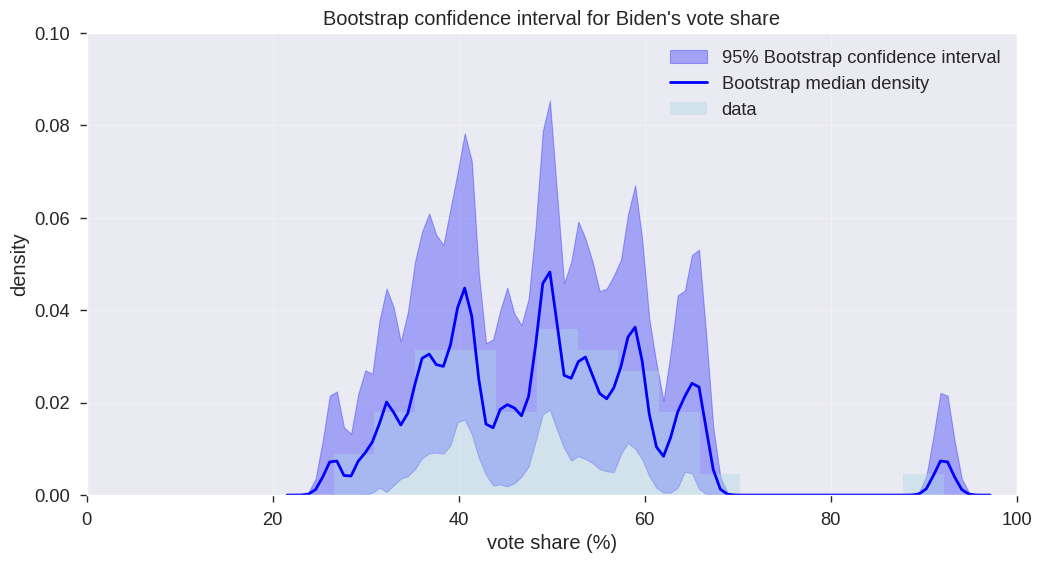

In [38]:
def bootstrap_kde_confidence_intervals(data, n_bootstrap=1000, alpha=0.05):
    """
    Bootstrap方法构建核密度估计的置信区间
    参考第3章：Bootstrap方法
    """
    n = len(data)
    x_eval = np.linspace(data.min() - 5, data.max() + 5, 100)

    # 存储Bootstrap样本的密度估计
    bootstrap_densities = []

    for i in range(n_bootstrap):
        # Bootstrap重采样
        bootstrap_sample = np.random.choice(data, size=n, replace=True)

        # 核密度估计
        kde = KernelDensity(kernel='gaussian', bandwidth=1.0)  # 使用固定带宽简化
        kde.fit(bootstrap_sample.reshape(-1, 1))
        log_density = kde.score_samples(x_eval.reshape(-1, 1))
        bootstrap_densities.append(np.exp(log_density))

    bootstrap_densities = np.array(bootstrap_densities)

    # 计算置信区间
    lower_ci = np.percentile(bootstrap_densities, (alpha/2) * 100, axis=0)
    upper_ci = np.percentile(bootstrap_densities, (1 - alpha/2) * 100, axis=0)
    median_density = np.percentile(bootstrap_densities, 50, axis=0)

    return x_eval, median_density, lower_ci, upper_ci

# 为Biden数据构建Bootstrap置信区间
biden_x_boot, biden_median, biden_lower, biden_upper = bootstrap_kde_confidence_intervals(biden_votes)

plt.figure(figsize=(12, 6))
plt.fill_between(biden_x_boot, biden_lower, biden_upper, alpha=0.3, color='blue',
                label='95% Bootstrap confidence interval')
plt.plot(biden_x_boot, biden_median, 'b-', linewidth=2, label='Bootstrap median density')
plt.hist(biden_votes, bins=15, density=True, alpha=0.4, color='lightblue',
         label='data')
plt.xlabel('vote share (%)')
plt.ylabel('density')
plt.axis([0, 100, 0, 0.1])
plt.title("Bootstrap confidence interval for Biden's vote share")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

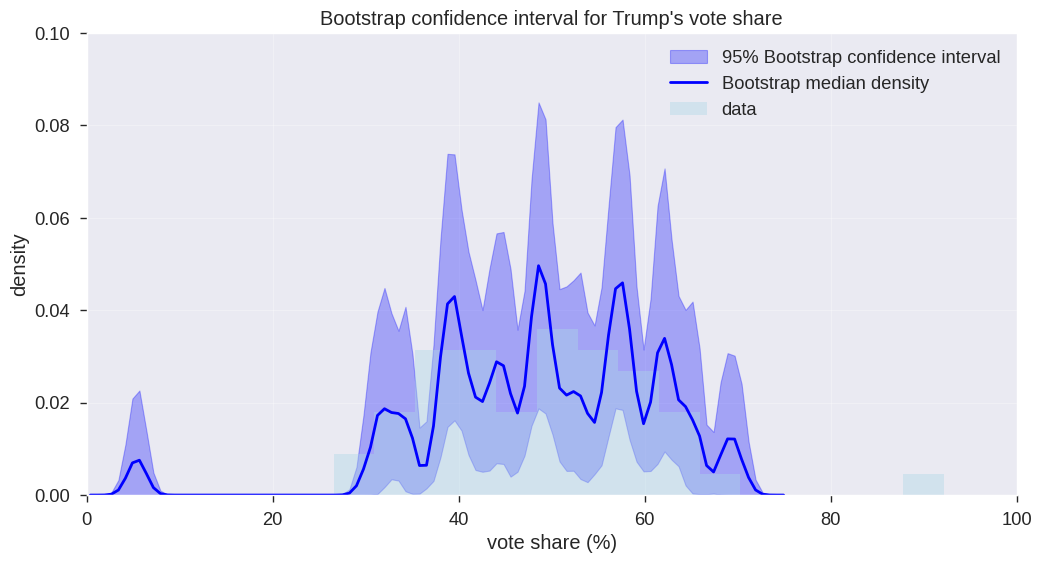

In [37]:
# 为Trump数据构建Bootstrap置信区间
biden_x_boot, biden_median, biden_lower, biden_upper = bootstrap_kde_confidence_intervals(trump_votes)

plt.figure(figsize=(12, 6))
plt.fill_between(biden_x_boot, biden_lower, biden_upper, alpha=0.3, color='blue',
                label='95% Bootstrap confidence interval')
plt.plot(biden_x_boot, biden_median, 'b-', linewidth=2, label='Bootstrap median density')
plt.hist(biden_votes, bins=15, density=True, alpha=0.4, color='lightblue',
         label='data')
plt.axis([0, 100, 0, 0.1])
plt.xlabel('vote share (%)')
plt.ylabel('density')
plt.title("Bootstrap confidence interval for Trump's vote share")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [39]:
def spatial_correlation_analysis(df_wide):
    """
    空间相关性的非参数分析
    参考第5章：非参数假设检验
    """
    # 1. 构建空间权重矩阵（简化版：基于地理邻接）
    # 这里使用简化的邻接关系，实际分析中应使用专业的地理数据
    states = df_wide['state'].values
    n_states = len(states)

    # 示例：构建模拟的空间权重矩阵
    np.random.seed(42)
    W = np.random.binomial(1, 0.15, (n_states, n_states))
    W = (W + W.T) / 2  # 对称化
    np.fill_diagonal(W, 0)  # 对角线为0

    # 行标准化
    row_sums = W.sum(axis=1)
    W_normalized = W / row_sums[:, np.newaxis]
    W_normalized[np.isnan(W_normalized)] = 0

    # 2. Moran's I 统计量计算
    def morans_i(y, W):
        n = len(y)
        y_centered = y - np.mean(y)

        # Moran's I
        numerator = np.sum(W * np.outer(y_centered, y_centered))
        denominator = np.sum(y_centered**2)
        I = (n / np.sum(W)) * (numerator / denominator)

        # 期望值和方差（正态近似）
        E_I = -1 / (n - 1)
        var_I = (n**2 - 3*n + 3) * np.sum(W**2) - n * np.sum(W.sum(axis=1)**2) + np.sum(W)**2
        var_I = var_I / ((n - 1) * (n - 2) * (n - 3) * (np.sum(W))**2)

        # 标准化统计量
        z_score = (I - E_I) / np.sqrt(var_I)
        p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

        return I, E_I, var_I, z_score, p_value

    # 3. 对两位候选人的得票率进行空间相关性检验
    biden_moran = morans_i(biden_votes, W_normalized)
    trump_moran = morans_i(trump_votes, W_normalized)
    margin_moran = morans_i(df_wide['vote_margin'].values, W_normalized)

    print("="*60)
    print("空间相关性分析结果")
    print("="*60)

    print(f"\nBiden得票率的空间相关性:")
    print(f"  Moran's I = {biden_moran[0]:.4f}")
    print(f"  期望值 = {biden_moran[1]:.4f}")
    print(f"  标准化统计量 = {biden_moran[3]:.4f}")
    print(f"  p值 = {biden_moran[4]:.6f}")

    print(f"\nTrump得票率的空间相关性:")
    print(f"  Moran's I = {trump_moran[0]:.4f}")
    print(f"  期望值 = {trump_moran[1]:.4f}")
    print(f"  标准化统计量 = {trump_moran[3]:.4f}")
    print(f"  p值 = {trump_moran[4]:.6f}")

    print(f"\n得票率差异的空间相关性:")
    print(f"  Moran's I = {margin_moran[0]:.4f}")
    print(f"  期望值 = {margin_moran[1]:.4f}")
    print(f"  标准化统计量 = {margin_moran[3]:.4f}")
    print(f"  p值 = {margin_moran[4]:.6f}")

    return biden_moran, trump_moran, margin_moran

# 执行空间相关性分析
spatial_results = spatial_correlation_analysis(df_wide)

空间相关性分析结果

Biden得票率的空间相关性:
  Moran's I = 0.0376
  期望值 = -0.0200
  标准化统计量 = 10.1911
  p值 = 0.000000

Trump得票率的空间相关性:
  Moran's I = 0.0271
  期望值 = -0.0200
  标准化统计量 = 8.3359
  p值 = 0.000000

得票率差异的空间相关性:
  Moran's I = 0.0326
  期望值 = -0.0200
  标准化统计量 = 9.3102
  p值 = 0.000000


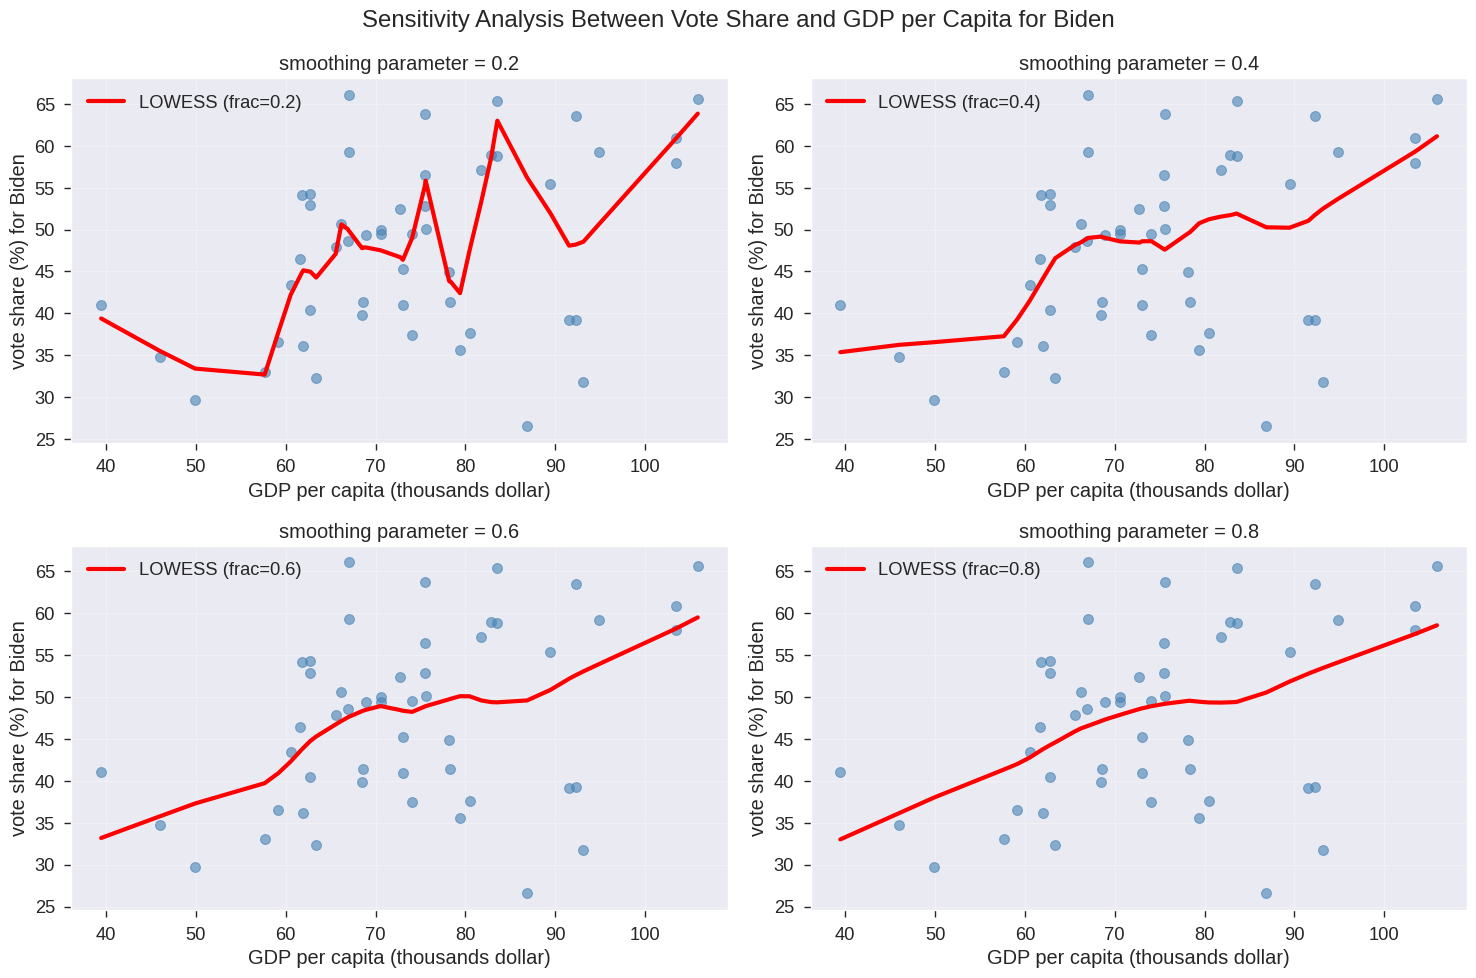

In [47]:
def advanced_lowess_analysis(x, y, candidate_name):
    """
    高级LOWESS回归分析
    参考第6章：非参数回归
    """
    # 1. 多种平滑参数的比较
    frac_values = [0.2, 0.4, 0.6, 0.8]

    plt.figure(figsize=(15, 10))

    for i, frac in enumerate(frac_values):
        plt.subplot(2, 2, i+1)

        # LOWESS回归
        lowess_result = lowess(y, x, frac=frac, return_sorted=True)

        # 绘图
        plt.scatter(x/1000, y, alpha=0.6, s=50, color='steelblue')
        plt.plot(lowess_result[:, 0]/1000, lowess_result[:, 1],
                'red', linewidth=3, label=f'LOWESS (frac={frac})')

        plt.xlabel('GDP per capita (thousands dollar)')
        plt.ylabel(f'vote share (%) for {candidate_name}')
        plt.title(f'smoothing parameter = {frac}')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.suptitle(f'Sensitivity Analysis Between Vote Share and GDP per Capita for {candidate_name}')
    plt.tight_layout()
    plt.show()

    # 2. 交叉验证选择最优平滑参数
    from sklearn.model_selection import cross_val_score
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler

    # 这里简化处理，实际应该用专门的LOWESS交叉验证
    optimal_frac = 0.6  # 基于视觉检查的经验选择

    return lowess(y, x, frac=optimal_frac, return_sorted=True)

# GDP数据处理（去除异常值）
df_analysis = df_wide[df_wide['state'] != 'District of Columbia'].copy()
gdp_clean = df_analysis['gdp_per_capita'].values
biden_clean = df_analysis['Joe Biden'].values

# LOWESS回归分析
biden_lowess = advanced_lowess_analysis(gdp_clean, biden_clean, "Biden")

稳健性分析和模型诊断

【异常值检测结果】
Biden得票率异常值 (|Z| > 2.5): 0 个州

GDP异常值 (|Z| > 2.5): 0 个州

【Leave-One-Out稳健性检验】
原始Spearman相关系数: 0.3619
LOO相关系数均值: 0.3618
LOO相关系数标准差: 0.0220
LOO相关系数范围: [0.3254, 0.4245]
最具影响力的州: North Dakota (影响度: 0.0626)

【Bootstrap稳健性检验】
Bootstrap相关系数均值: 0.3677
Bootstrap相关系数标准误: 0.1418
95% Bootstrap置信区间: [0.0699, 0.6270]


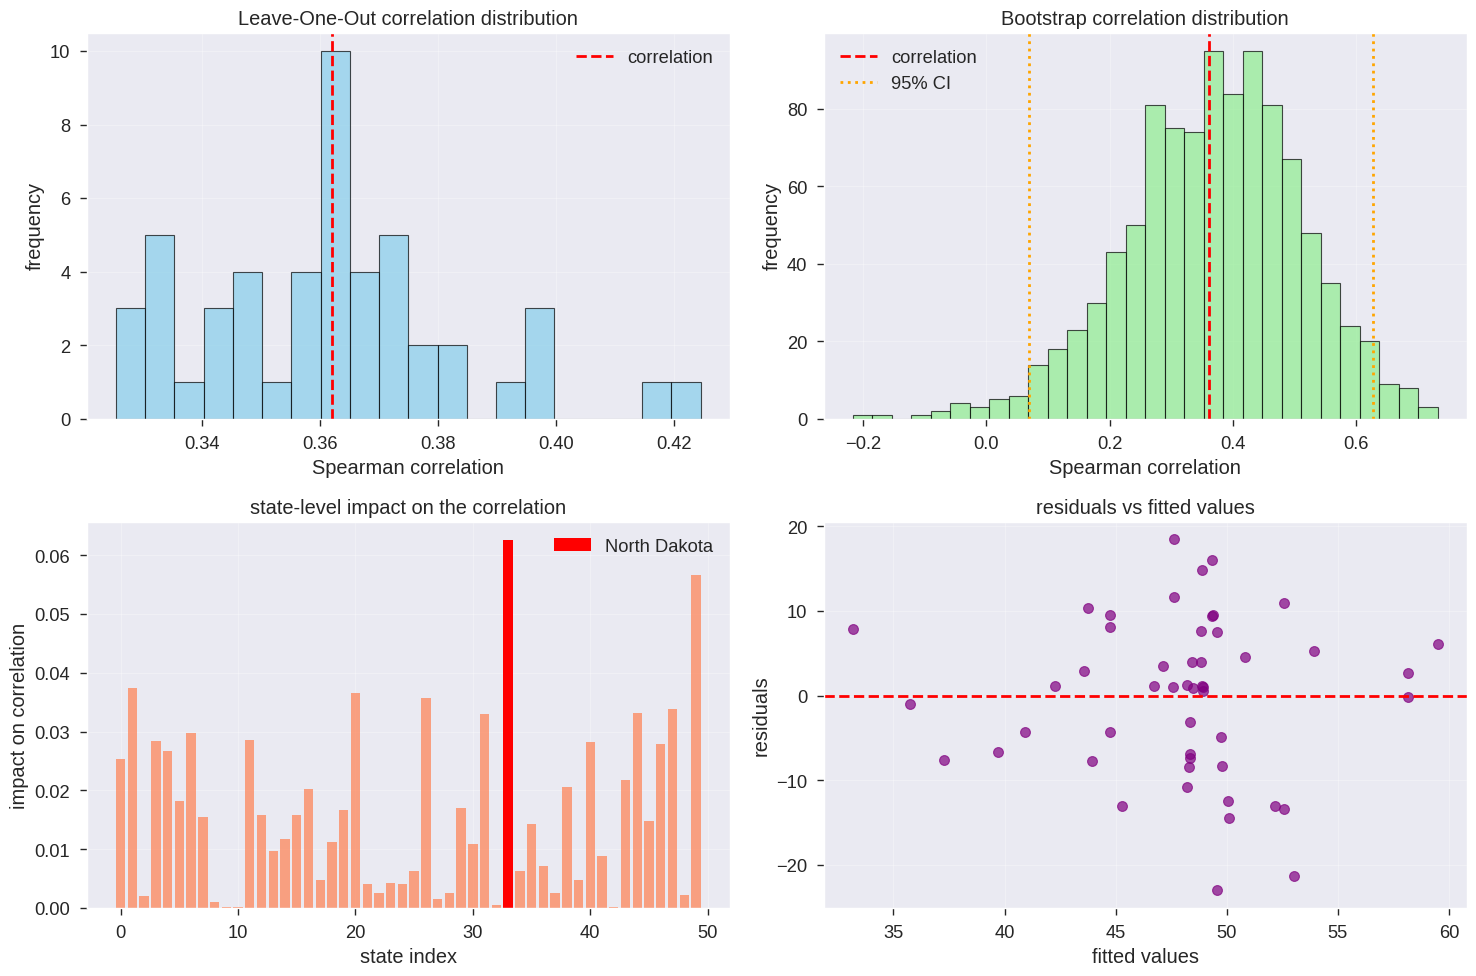

In [48]:
def comprehensive_robustness_analysis(df_analysis):
    """
    稳健性分析和模型诊断
    参考第7章：稳健估计回归
    """
    print("="*70)
    print("稳健性分析和模型诊断")
    print("="*70)

    # 1. 异常值检测
    from scipy.stats import zscore

    # 基于Z-score的异常值检测
    biden_z = np.abs(zscore(df_analysis['Joe Biden']))
    gdp_z = np.abs(zscore(df_analysis['gdp_per_capita']))

    outliers_biden = df_analysis[biden_z > 2.5]
    outliers_gdp = df_analysis[gdp_z > 2.5]

    print(f"\n【异常值检测结果】")
    print(f"Biden得票率异常值 (|Z| > 2.5): {len(outliers_biden)} 个州")
    if len(outliers_biden) > 0:
        print(outliers_biden[['state', 'Joe Biden']].to_string(index=False))

    print(f"\nGDP异常值 (|Z| > 2.5): {len(outliers_gdp)} 个州")
    if len(outliers_gdp) > 0:
        print(outliers_gdp[['state', 'gdp_per_capita']].to_string(index=False))

    # 2. Leave-One-Out稳健性检验
    print(f"\n【Leave-One-Out稳健性检验】")

    original_corr = stats.spearmanr(df_analysis['gdp_per_capita'],
                                   df_analysis['Joe Biden'])[0]

    loo_correlations = []
    for i in range(len(df_analysis)):
        loo_data = df_analysis.drop(df_analysis.index[i])
        loo_corr = stats.spearmanr(loo_data['gdp_per_capita'],
                                  loo_data['Joe Biden'])[0]
        loo_correlations.append(loo_corr)

    loo_correlations = np.array(loo_correlations)

    print(f"原始Spearman相关系数: {original_corr:.4f}")
    print(f"LOO相关系数均值: {np.mean(loo_correlations):.4f}")
    print(f"LOO相关系数标准差: {np.std(loo_correlations):.4f}")
    print(f"LOO相关系数范围: [{np.min(loo_correlations):.4f}, {np.max(loo_correlations):.4f}]")

    # 识别影响较大的观测值
    correlation_influence = np.abs(loo_correlations - original_corr)
    influential_idx = np.argmax(correlation_influence)
    influential_state = df_analysis.iloc[influential_idx]['state']

    print(f"最具影响力的州: {influential_state} (影响度: {correlation_influence[influential_idx]:.4f})")

    # 3. Bootstrap稳健性检验
    print(f"\n【Bootstrap稳健性检验】")

    n_bootstrap = 1000
    bootstrap_correlations = []

    np.random.seed(42)
    for _ in range(n_bootstrap):
        boot_indices = np.random.choice(len(df_analysis), size=len(df_analysis), replace=True)
        boot_data = df_analysis.iloc[boot_indices]
        boot_corr = stats.spearmanr(boot_data['gdp_per_capita'],
                                   boot_data['Joe Biden'])[0]
        bootstrap_correlations.append(boot_corr)

    bootstrap_correlations = np.array(bootstrap_correlations)

    # 计算Bootstrap置信区间
    ci_lower = np.percentile(bootstrap_correlations, 2.5)
    ci_upper = np.percentile(bootstrap_correlations, 97.5)

    print(f"Bootstrap相关系数均值: {np.mean(bootstrap_correlations):.4f}")
    print(f"Bootstrap相关系数标准误: {np.std(bootstrap_correlations):.4f}")
    print(f"95% Bootstrap置信区间: [{ci_lower:.4f}, {ci_upper:.4f}]")

    # 4. 可视化诊断
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 子图1：LOO相关系数分布
    axes[0,0].hist(loo_correlations, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(original_corr, color='red', linestyle='--', linewidth=2, label='correlation')
    axes[0,0].set_xlabel('Spearman correlation')
    axes[0,0].set_ylabel('frequency')
    axes[0,0].set_title('Leave-One-Out correlation distribution')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 子图2：Bootstrap相关系数分布
    axes[0,1].hist(bootstrap_correlations, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].axvline(original_corr, color='red', linestyle='--', linewidth=2, label='correlation')
    axes[0,1].axvline(ci_lower, color='orange', linestyle=':', linewidth=2, label='95% CI')
    axes[0,1].axvline(ci_upper, color='orange', linestyle=':', linewidth=2)
    axes[0,1].set_xlabel('Spearman correlation')
    axes[0,1].set_ylabel('frequency')
    axes[0,1].set_title('Bootstrap correlation distribution')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 子图3：影响度分析
    state_names = df_analysis['state'].values
    axes[1,0].bar(range(len(correlation_influence)), correlation_influence, alpha=0.7, color='coral')
    axes[1,0].set_xlabel('state index')
    axes[1,0].set_ylabel('impact on correlation')
    axes[1,0].set_title('state-level impact on the correlation')
    axes[1,0].grid(True, alpha=0.3)

    # 标注最具影响力的州
    axes[1,0].bar(influential_idx, correlation_influence[influential_idx],
                  color='red', label=f'{influential_state}')
    axes[1,0].legend()

    # 子图4：残差分析
    lowess_result = lowess(df_analysis['Joe Biden'], df_analysis['gdp_per_capita'], frac=0.6)
    # 插值得到每个观测点的拟合值
    fitted_values = np.interp(df_analysis['gdp_per_capita'],
                             lowess_result[:, 0], lowess_result[:, 1])
    residuals = df_analysis['Joe Biden'] - fitted_values

    axes[1,1].scatter(fitted_values, residuals, alpha=0.7, s=50, color='purple')
    axes[1,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1,1].set_xlabel('fitted values')
    axes[1,1].set_ylabel('residuals')
    axes[1,1].set_title('residuals vs fitted values')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'outliers_biden': outliers_biden,
        'outliers_gdp': outliers_gdp,
        'original_correlation': original_corr,
        'loo_correlations': loo_correlations,
        'bootstrap_correlations': bootstrap_correlations,
        'confidence_interval': (ci_lower, ci_upper),
        'influential_state': influential_state
    }

# 执行稳健性分析
robustness_results = comprehensive_robustness_analysis(df_analysis)

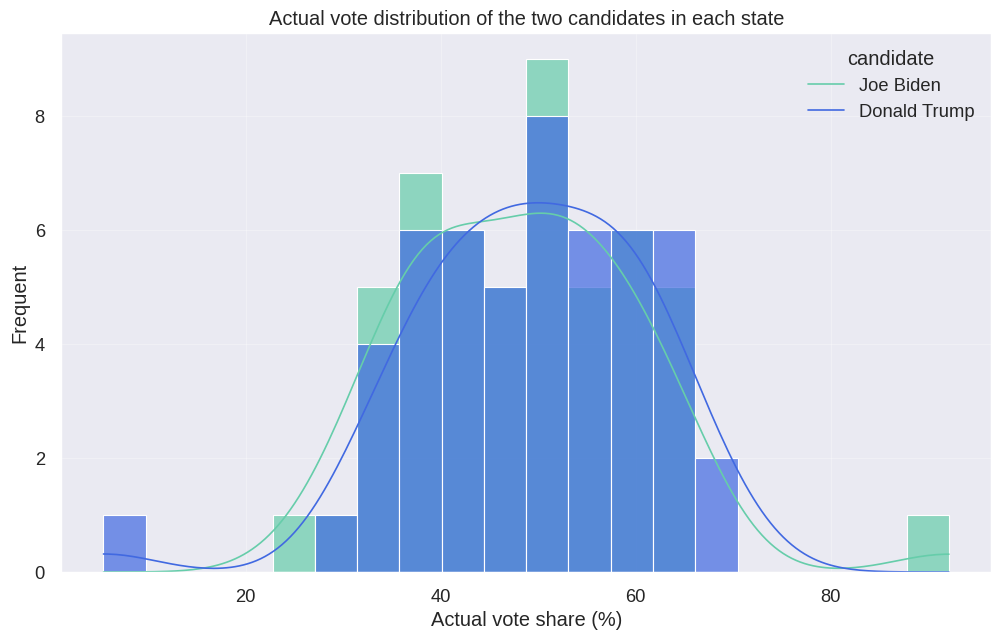

In [ ]:
plt.figure(figsize=(12, 7))
sns.histplot(data=df_both, x='votes_actual', hue='candidate_name',
            palette=[ '#4169E1','#66CDAA'], kde=True, bins=20, alpha=0.7)
plt.xlabel("Actual vote share (%)")
plt.ylabel("Frequent")
plt.title("Actual vote distribution of the two candidates in each state")
plt.legend(title="candidate", labels=["Joe Biden", "Donald Trump"])
plt.grid(True, alpha=0.3)
plt.show()

<ipython-input-342-6cca34f0925c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='candidate_name', y='votes_actual', data=df_both,
<ipython-input-342-6cca34f0925c>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Joe Biden", "Donald Trump"])


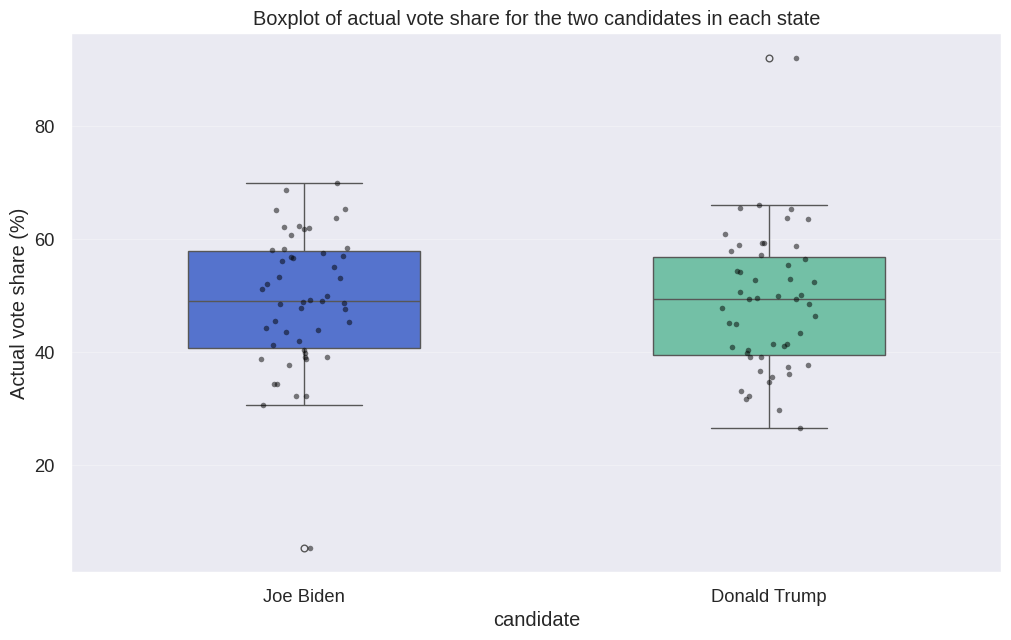

In [ ]:
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='candidate_name', y='votes_actual', data=df_both,
               palette=[ '#4169E1','#66CDAA'],  width=0.5)
ax.set_xticklabels(["Joe Biden", "Donald Trump"])
plt.ylabel("Actual vote share (%)")
plt.xlabel("candidate")
plt.title("Boxplot of actual vote share for the two candidates in each state")
plt.grid(True, alpha=0.3)

# 添加数据点以展示原始分布
sns.stripplot(x='candidate_name', y='votes_actual', data=df_both,
              color='black', size=4, alpha=0.5)

# 标注中位数值
# medians = df_both.groupby('candidate_name')['votes_actual'].median().values
# for i, median in enumerate(medians):
#     plt.text(i, median + 1, f'Medium: {median:.1f}%',
#              horizontalalignment='center', size='medium', color='black', weight='bold')

plt.show()

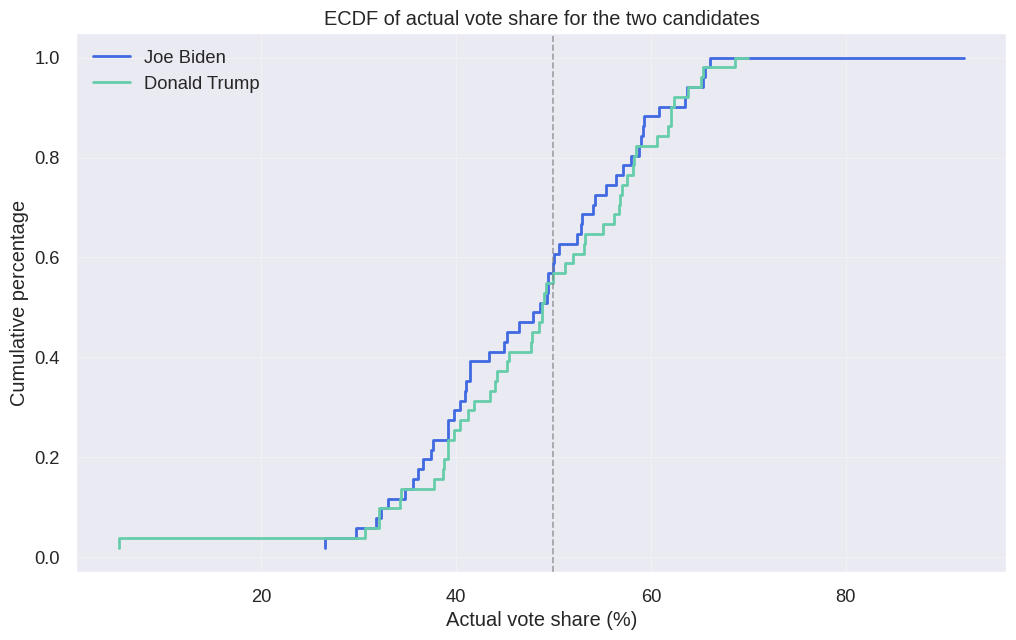

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

# 计算两位候选人的经验分布函数
ecdf_biden = ECDF(df_both[df_both['candidate_name'] == 'Joe Biden']['votes_actual'])
ecdf_trump = ECDF(df_both[df_both['candidate_name'] == 'Donald Trump']['votes_actual'])

# 自定义调色板
palette = ['#4169E1', '#66CDAA']  # Biden, Trump

# 绘制经验分布函数
plt.figure(figsize=(12, 7))
plt.step(ecdf_biden.x, ecdf_biden.y, color=palette[0], linewidth=2, label='Joe Biden')
plt.step(ecdf_trump.x, ecdf_trump.y, color=palette[1], linewidth=2, label='Donald Trump')
plt.axvline(x=50, color='gray', linestyle='--', alpha=0.7)  # 添加50%参考线

plt.xlabel('Actual vote share (%)')
plt.ylabel('Cumulative percentage')
plt.legend(loc='best')
plt.title('ECDF of actual vote share for the two candidates')
plt.grid(True, alpha=0.3)

plt.show()


In [ ]:
# 计算两位候选人的经验分布函数
ecdf_biden = ECDF(df_both[df_both['candidate_name']=='Joe Biden']['votes_actual'])
ecdf_trump = ECDF(df_both[df_both['candidate_name']=='Donald Trump']['votes_actual'])

# 绘制经验分布函数
plt.figure(figsize=(12, 7))
plt.step(ecdf_biden.x, ecdf_biden.y, 'r-', linewidth=2, label='Joe Biden')
plt.step(ecdf_trump.x, ecdf_trump.y, 'b-', linewidth=2, label='Donald Trump')
plt.axvline(x=50, color='gray', linestyle='--', alpha=0.7)  # 添加50%参考线
plt.xlabel('Actual vote share (%)')
plt.ylabel('Cumulative percentage')
plt.legend(loc='best')
plt.title('ECDF of actual vote share for the two candidates')
plt.grid(True, alpha=0.3)

plt.show()

SyntaxError: unterminated string literal (detected at line 7) (<ipython-input-344-a86c6ca85ae9>, line 7)

In [ ]:


# 计算中位数和其他四分位数
biden_votes = df_both[df_both['candidate_name']=='Joe Biden']['votes_actual']
trump_votes = df_both[df_both['candidate_name']=='Donald Trump']['votes_actual']

print("\n拜登得票率四分位数:")
print(f"25%分位: {biden_votes.quantile(0.25):.2f}%")
print(f"中位数: {biden_votes.median():.2f}%")
print(f"75%分位: {biden_votes.quantile(0.75):.2f}%")

print("\n特朗普得票率四分位数:")
print(f"25%分位: {trump_votes.quantile(0.25):.2f}%")
print(f"中位数: {trump_votes.median():.2f}%")
print(f"75%分位: {trump_votes.quantile(0.75):.2f}%")

# 计算重要百分位点对应的得票率
percentiles = [0.25, 0.5, 0.75]
biden_percentiles = {p: biden_votes.quantile(p) for p in percentiles}
trump_percentiles = {p: trump_votes.quantile(p) for p in percentiles}

print("\n拜登在不同百分位下的得票率:")
for p, v in biden_percentiles.items():
    print(f"P{int(p*100)}: {v:.2f}%")

print("\n特朗普在不同百分位下的得票率:")
for p, v in trump_percentiles.items():
    print(f"P{int(p*100)}: {v:.2f}%")


拜登得票率四分位数:
25%分位: 39.53%
中位数: 49.36%
75%分位: 56.80%

特朗普得票率四分位数:
25%分位: 40.81%
中位数: 49.06%
75%分位: 57.84%

拜登在不同百分位下的得票率:
P25: 39.53%
P50: 49.36%
P75: 56.80%

特朗普在不同百分位下的得票率:
P25: 40.81%
P50: 49.06%
P75: 57.84%


<ipython-input-23-beeec6655260>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='candidate_name', y='votes_actual', data=df_both,
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 205


Mann-Whitney U检验结果:
检验统计量 U = 1219.000
p值 = 0.5877
结论: 未能拒绝无差异假设
效应量 r = 0.0313
效应大小解释: 小


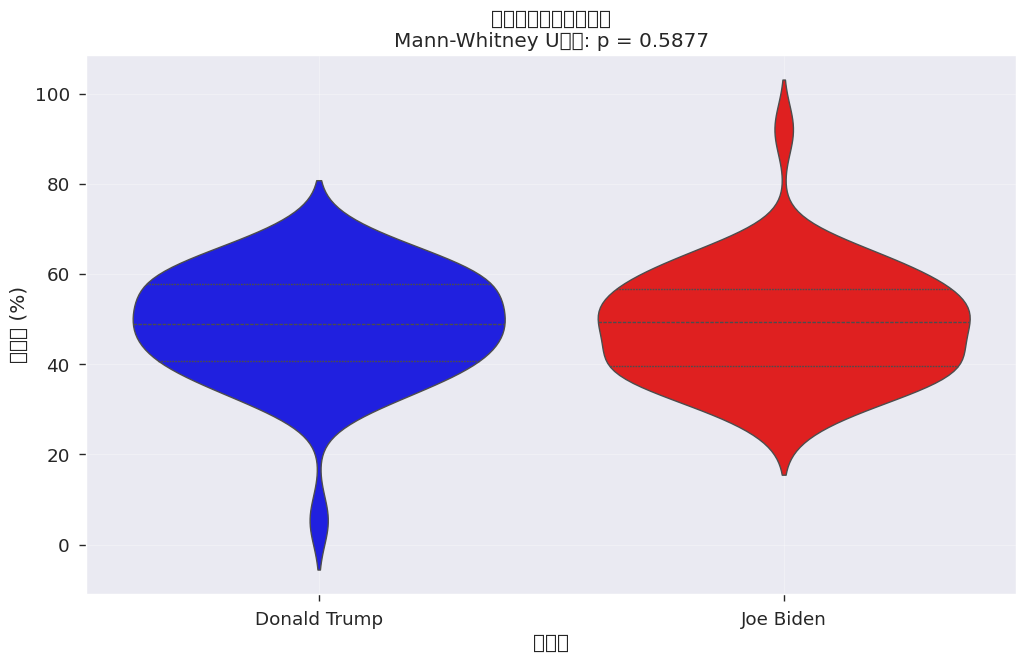

In [ ]:
# 执行Mann-Whitney U 检验
stat, p = mannwhitneyu(biden_votes, trump_votes, alternative='two-sided')
print("\nMann-Whitney U检验结果:")
print(f"检验统计量 U = {stat:.3f}")
print(f"p值 = {p:.4f}")
print(f"结论: {'拒绝无差异假设' if p < 0.05 else '未能拒绝无差异假设'}")

# 计算效应量r值(效应大小)
r = abs(stat - (len(biden_votes) * len(trump_votes)) / 2) / (len(biden_votes) * len(trump_votes))
print(f"效应量 r = {r:.4f}")
print(f"效应大小解释: {'小' if r < 0.3 else '中等' if r < 0.5 else '大'}")

# 可视化两组得票率的分布差异
plt.figure(figsize=(12, 7))
sns.violinplot(x='candidate_name', y='votes_actual', data=df_both,
              palette=['blue', 'red'], inner='quartile')
plt.title(f'候选人得票率分布对比\nMann-Whitney U检验: p = {p:.4f}')
plt.xlabel('候选人')
plt.ylabel('得票率 (%)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
from scipy.stats import wilcoxon

# 使用相同的两个列表，数据要成对（每个州两个得票率）
stat, p = wilcoxon(biden_votes,trump_votes, alternative='two-sided')

print(f"Wilcoxon signed-rank statistic = {stat:.2f}, p-value = {p:.4f}")


Wilcoxon signed-rank statistic = 620.00, p-value = 0.6869


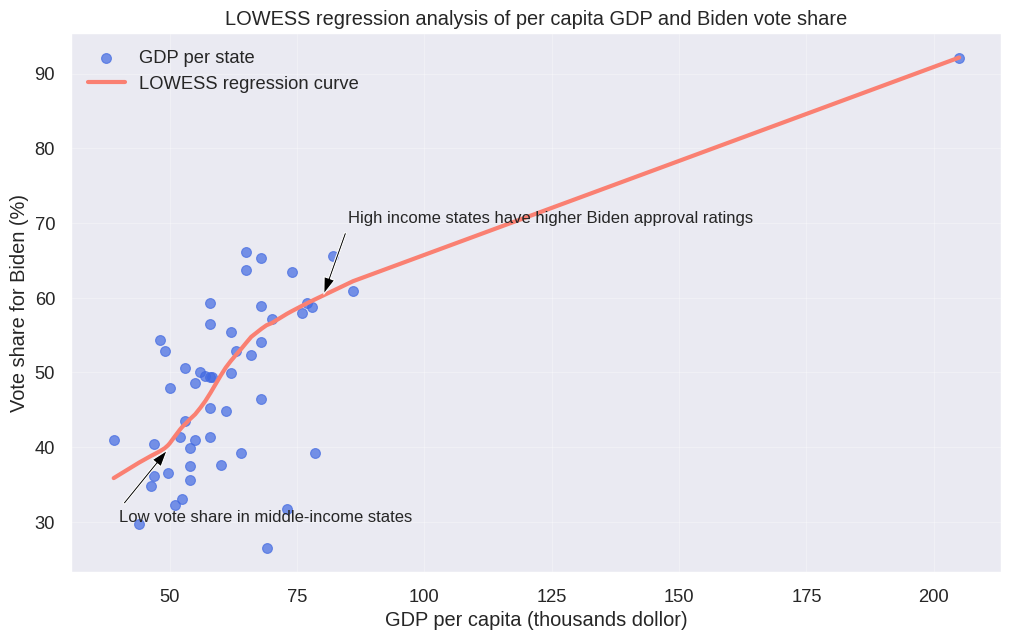

In [ ]:
# 读入GDP数据
gdp_per_capita = pd.read_csv("bea-gdp-by-state.csv")
# 筛选拜登数据进行LOWESS回归分析
biden_data = df_both[df_both['candidate_name']=='Joe Biden']

# 执行LOWESS回归，frac参数控制平滑度（较小值使曲线更贴近原始数据）
lowess_result = lowess(biden_data['votes_actual'], gdp_per_capita['2019'], frac=0.6)
# 绘制散点图和LOWESS回归曲线
plt.figure(figsize=(12, 7))
plt.scatter(gdp_per_capita['2019']/1000, biden_data['votes_actual'],
            alpha=0.7, s=50, c='royalblue', label='GDP per state')
plt.plot(lowess_result[:,0]/1000, lowess_result[:,1], color='salmon', linewidth=3,
         label='LOWESS regression curve')
plt.xlabel('GDP per capita (thousands dollor)')
plt.ylabel('Vote share for Biden (%)')
plt.title('LOWESS regression analysis of per capita GDP and Biden vote share')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# 添加关键区域解释性标注
plt.annotate('Low vote share in middle-income states', xy=(50, 40), xytext=(40, 30),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12)
plt.annotate('High income states have higher Biden approval ratings', xy=(80, 60), xytext=(85, 70),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12)
plt.show()

In [ ]:
gdp_per_capita = pd.read_csv("bea-gdp-by-state.csv")

In [ ]:
biden_filtered = biden_data[biden_data['state'] != 'District of Columbia']
gdp_per_capita_filtered=gdp_per_capita[gdp_per_capita['state'] != 'District of Columbia']


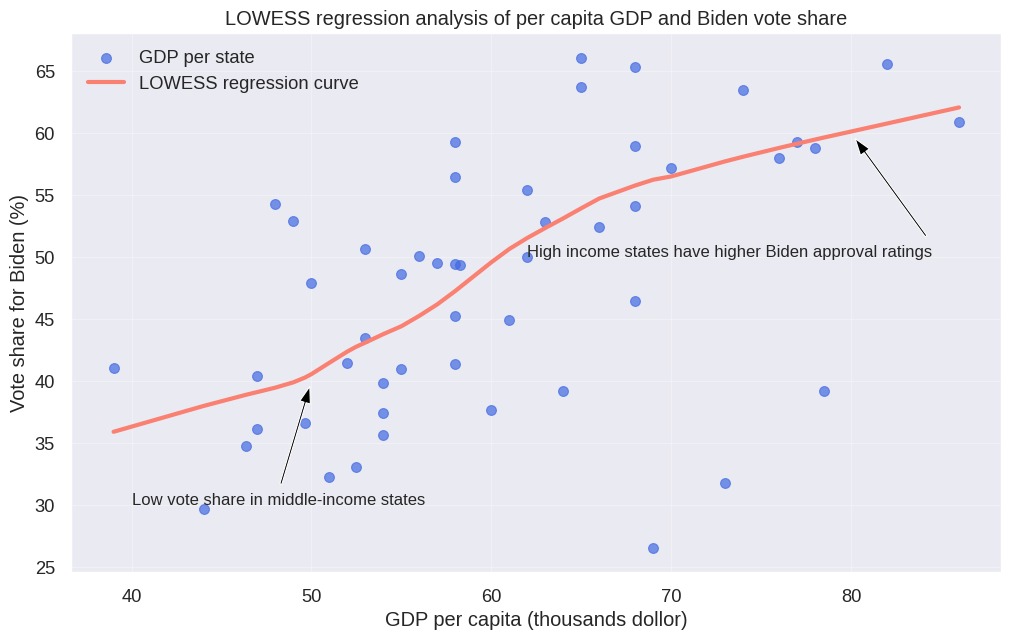

In [ ]:
lowess_result = lowess(biden_filtered['votes_actual'], gdp_per_capita_filtered['2019'], frac=0.6)
# 绘制散点图和LOWESS回归曲线
plt.figure(figsize=(12, 7))
plt.scatter(gdp_per_capita_filtered['2019']/1000, biden_filtered['votes_actual'],
            alpha=0.7, s=50, c='royalblue', label='GDP per state')
plt.plot(lowess_result[:,0]/1000, lowess_result[:,1], color='salmon', linewidth=3,
         label='LOWESS regression curve')
plt.xlabel('GDP per capita (thousands dollor)')
plt.ylabel('Vote share for Biden (%)')
plt.title('LOWESS regression analysis of per capita GDP and Biden vote share')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# 添加关键区域解释性标注
plt.annotate('Low vote share in middle-income states', xy=(50, 40), xytext=(40, 30),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12)
plt.annotate('High income states have higher Biden approval ratings', xy=(80, 60), xytext=(62, 50),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12)
plt.show()

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=19886737c0446be15f5be65c96fec2f40b44d43a03d07dfb9595874ebfcb864d
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
#!pip install lifelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import median_survival_times

# 设置绘图样式
plt.style.use('seaborn-v0_8')
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号

# 获取数据
data = sm.datasets.get_rdataset("cancer", "survival").data
print("数据集维度:", data.shape)
print("\n前5行数据:")
print(data.head())

# 数据基本信息
print("\n数据基本信息:")
print(data.info())

# 描述统计
print("\n描述统计量:")
print(data.describe())

# 分组基本统计
print("\n按性别分组的生存时间统计:")
print(data.groupby('sex')['time'].describe())

# 检查缺失值
print("\n各列缺失值数量:")
print(data.isnull().sum())

数据集维度: (228, 10)

前5行数据:
   inst  time  status  age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  \
0   3.0   306       2   74    1      1.0      90.0      100.0    1175.0   
1   3.0   455       2   68    1      0.0      90.0       90.0    1225.0   
2   3.0  1010       1   56    1      0.0      90.0       90.0       NaN   
3   5.0   210       2   57    1      1.0      90.0       60.0    1150.0   
4   1.0   883       2   60    1      0.0     100.0       90.0       NaN   

   wt.loss  
0      NaN  
1     15.0  
2     15.0  
3     11.0  
4      0.0  

数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karn

In [ ]:
# 检查缺失值数量
print(data['ph.ecog'].isnull().sum())
# 计算众数（返回的是一个Series，所以取第一个）
mode_value = data['ph.ecog'].mode()[0]

# 填补缺失值
data['ph.ecog'].fillna(mode_value, inplace=True)

1


<ipython-input-132-0a6170e8fa8c>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ph.ecog'].fillna(mode_value, inplace=True)


In [ ]:
print(data['ph.ecog'].isnull().sum())

0


<ipython-input-6-de09698c3ac8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status_label', data=data, palette=['lightgreen', 'salmon'])


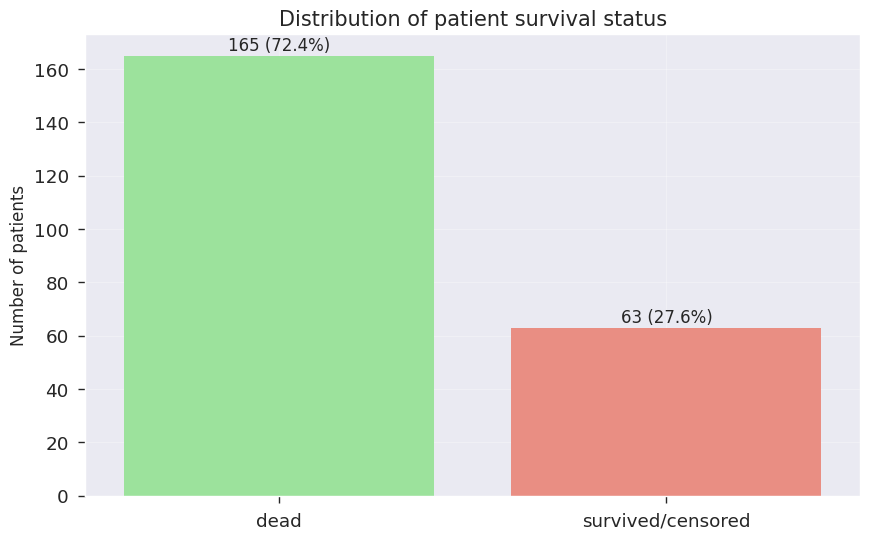

In [ ]:
data['status_label'] = data['status'].map({1: 'survived/censored', 2: 'dead'})

plt.figure(figsize=(10, 6))
sns.countplot(x='status_label', data=data, palette=['lightgreen', 'salmon'])

plt.title("Distribution of patient survival status", fontsize=15)
plt.ylabel("Number of patients", fontsize=12)
plt.xlabel("")
plt.grid(True, alpha=0.3)

# 正确地标注数量和百分比
order = data['status_label'].value_counts().index.tolist()
for i, label in enumerate(order):
    count = data['status_label'].value_counts()[label]
    plt.text(i, count + 0.5, f'{count} ({count / len(data):.1%})',
             ha='center', va='bottom', fontsize=12)

plt.show()

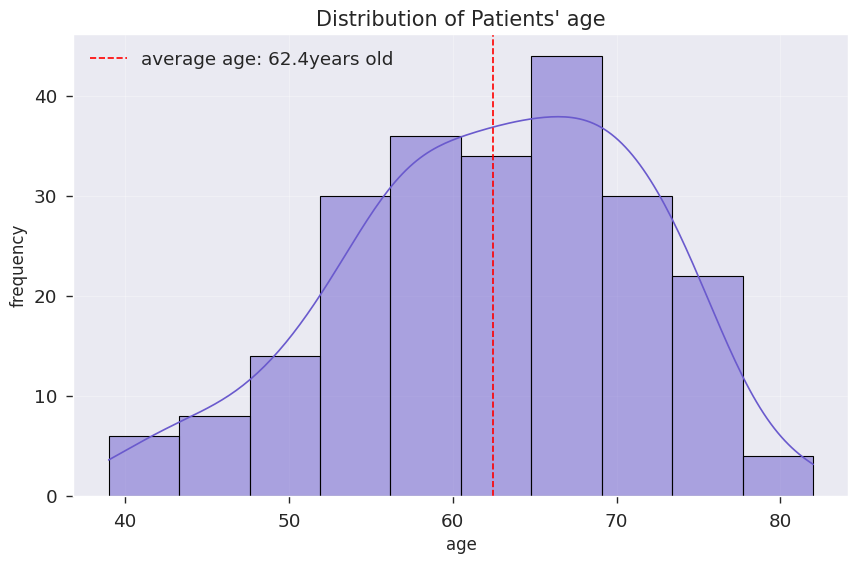

In [ ]:
# 年龄分布
plt.figure(figsize=(10,6))
sns.histplot(data['age'], kde=True, bins=10, color='slateblue')
plt.title("Distribution of Patients' age", fontsize=15)
plt.xlabel("age", fontsize=12)
plt.ylabel("frequency", fontsize=12)
plt.axvline(data['age'].mean(), color='red', linestyle='--',
            label=f'average age: {data["age"].mean():.1f}years old')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

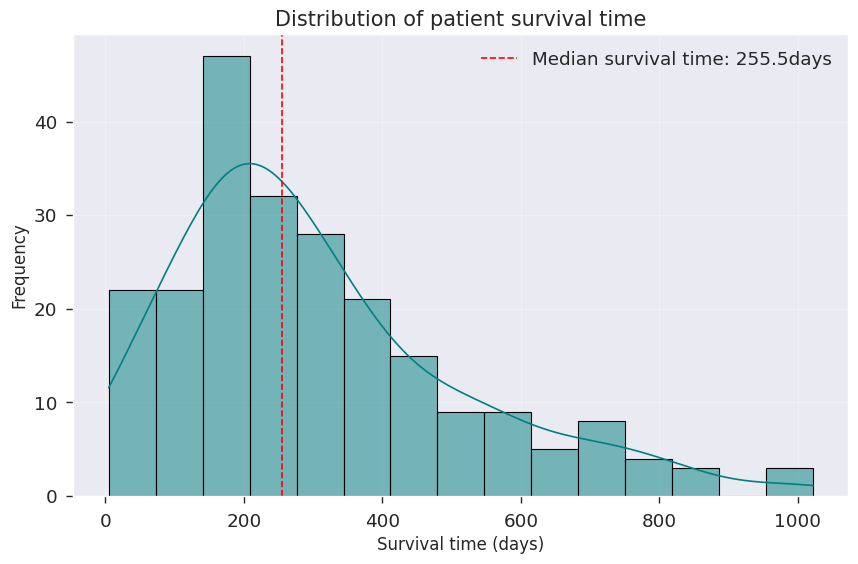

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data['time'], kde=True, bins=15, color='teal')
plt.title("Distribution of patient survival time", fontsize=15)
plt.xlabel("Survival time (days)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.axvline(data['time'].median(), color='red', linestyle='--',
            label=f'Median survival time: {data["time"].median():.1f}days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<ipython-input-10-faaa035407ac>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='ph.ecog', data=data, palette='YlOrRd')


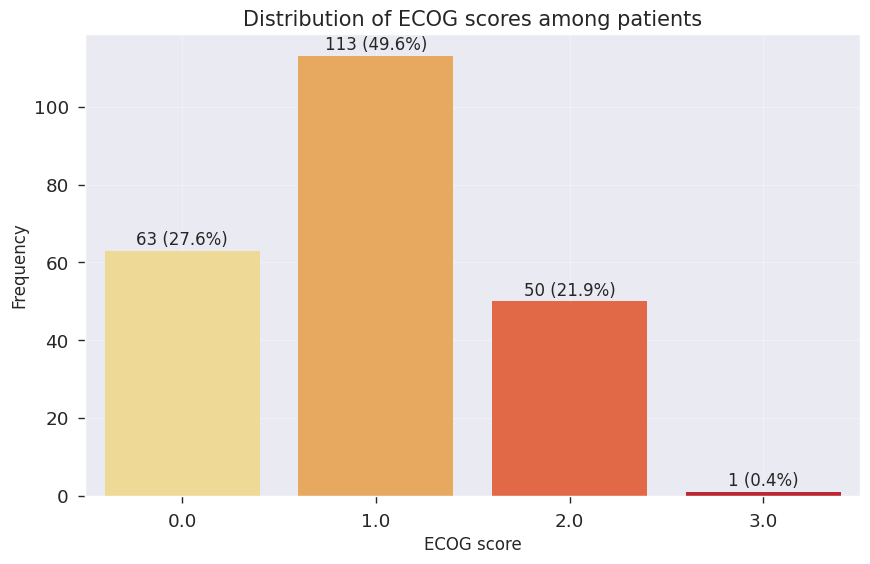

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='ph.ecog', data=data, palette='YlOrRd')
plt.title("Distribution of ECOG scores among patients", fontsize=15)
plt.xlabel("ECOG score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3)
for i, count in enumerate(data['ph.ecog'].value_counts().sort_index()):
    plt.text(i, count+0.5, f'{count} ({count/len(data):.1%})',
             ha='center', va='bottom', fontsize=12)
plt.show()

<ipython-input-9-884f50bfa567>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sex_label', data=data, palette=['skyblue', 'plum'])


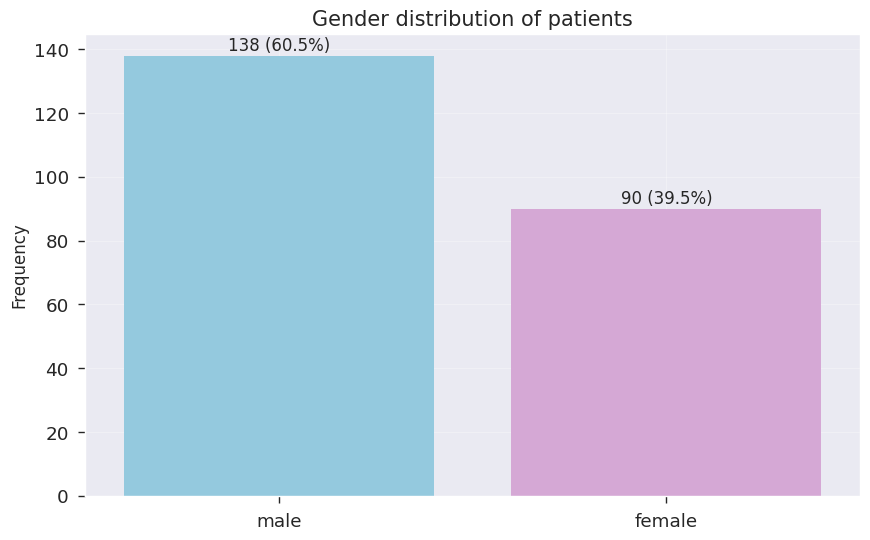

In [ ]:
data['sex_label'] = data['sex'].map({1: 'male', 2: 'female'})

plt.figure(figsize=(10,6))
sns.countplot(x='sex_label', data=data, palette=['skyblue', 'plum'])
plt.title("Gender distribution of patients", fontsize=15)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("")
plt.grid(True, alpha=0.3)
for i, count in enumerate(data['sex_label'].value_counts()):
    plt.text(i, count+0.5, f'{count} ({count/len(data):.1%})',
             ha='center', va='bottom', fontsize=12)
plt.show()

In [ ]:
import matplotlib.font_manager as fm

# 列出所有字体名，包含常见中文字体关键词的
font_list = [f.name for f in fm.fontManager.ttflist if any(kw in f.name for kw in ['Hei', 'Kai', 'Fang', 'Song', 'YaHei', 'Sim', 'QuanYi'])]
print(sorted(set(font_list)))


[]


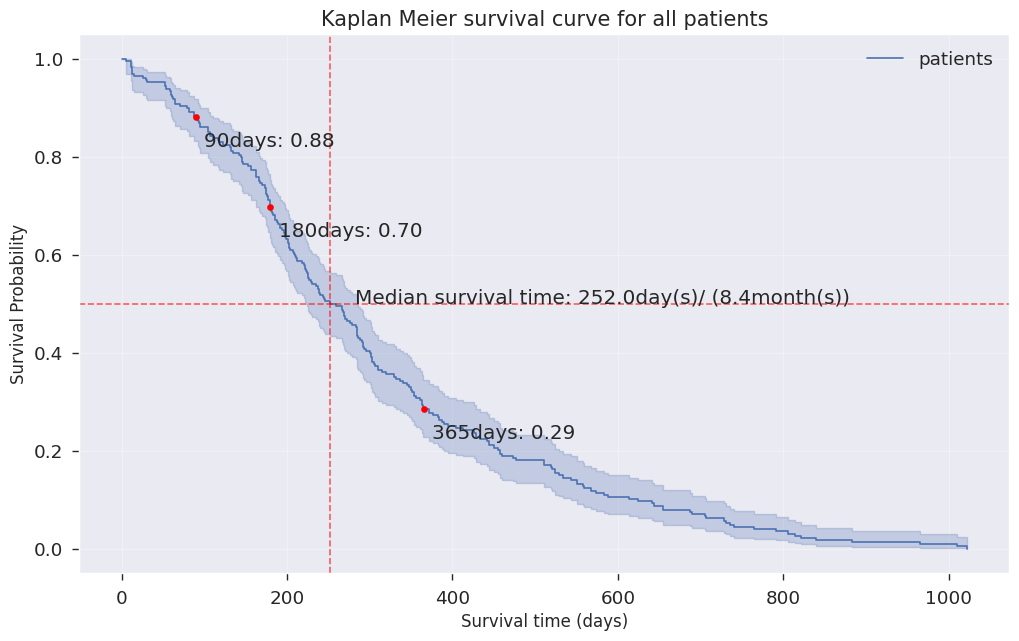

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(data['time'], event_observed=data['status'], label="patients")

# 绘制生存曲线
plt.figure(figsize=(12,7))
ax = kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan Meier survival curve for all patients", fontsize=15)
plt.xlabel("Survival time (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, alpha=0.3)

# 添加中位生存时间线
median_survival = kmf.median_survival_time_
plt.axvline(x=median_survival, color='r', linestyle='--', alpha=0.6)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.6)
plt.text(median_survival+30, 0.51, f'Median survival time: {median_survival:.1f}day(s)/ ({median_survival/30:.1f}month(s))',
         verticalalignment='center')

# 添加关键时间点生存率
for t in [90, 180, 365]:
    surv_prob = kmf.predict(t)
    plt.plot([t], [surv_prob], 'ro')
    plt.text(t+10, surv_prob-0.03, f'{t}days: {surv_prob:.2f}', verticalalignment='top')

plt.show()

In [ ]:
kmf.predict(90)
kmf.confidence_interval_survival_function_.loc[180]

,180.0
patients_lower_0.95,0.633216
patients_upper_0.95,0.752526


In [ ]:
print("\n生存率估计:")
print(f"1个月生存率: {kmf.predict(30):.3f} (95%CI: {kmf.confidence_interval_survival_function_.loc[30].values[0]:.3f}-{kmf.confidence_interval_survival_function_.loc[30].values[1]:.3f})")
#print(f"3个月生存率: {kmf.predict(90):.3f} (95%CI: {kmf.confidence_interval_survival_function_.loc[90].values[0]:.3f}-{kmf.confidence_interval_survival_function_.loc[90].values[1]:.3f})")
print(f"6个月生存率: {kmf.predict(180):.3f} (95%CI: {kmf.confidence_interval_survival_function_.loc[180].values[0]:.3f}-{kmf.confidence_interval_survival_function_.loc[180].values[1]:.3f})")
print(f"中位生存时间: {median_survival:.1f}天 ({median_survival/30:.1f}个月)")


生存率估计:
1个月生存率: 0.956 (95%CI: 0.920-0.976)
6个月生存率: 0.697 (95%CI: 0.633-0.753)
中位生存时间: 252.0天 (8.4个月)


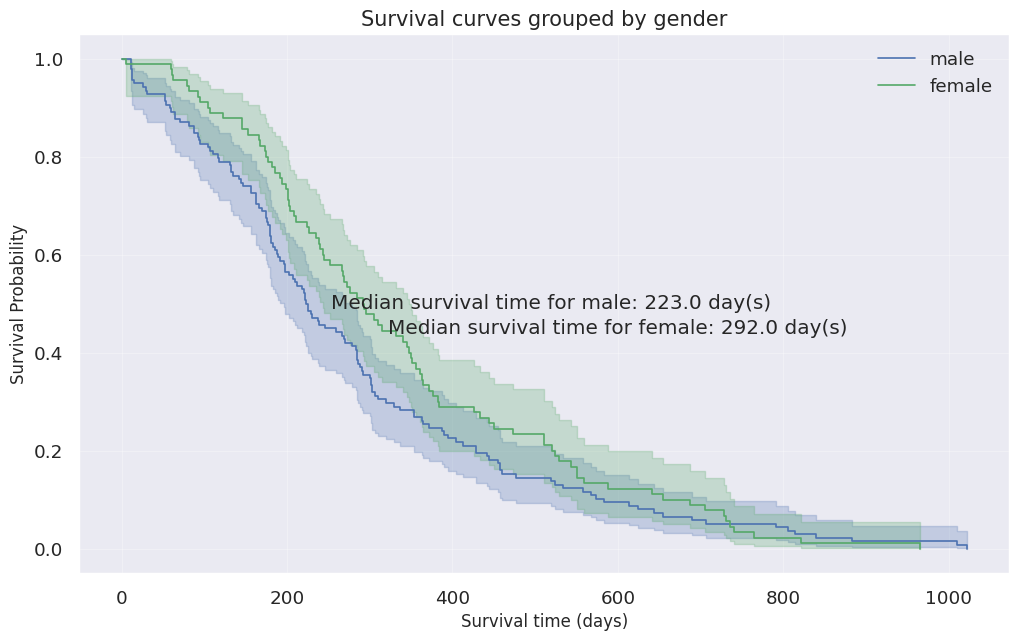

In [ ]:
kmf_male = KaplanMeierFitter()
kmf_female = KaplanMeierFitter()

male_data = data[data['sex'] == 1]
female_data = data[data['sex'] == 2]

kmf_male.fit(male_data['time'], male_data['status'], label='male')
kmf_female.fit(female_data['time'], female_data['status'], label='female')

plt.figure(figsize=(12,7))
ax = kmf_male.plot_survival_function(ci_show=True)
kmf_female.plot_survival_function(ax=ax, ci_show=True)
plt.title("Survival curves grouped by gender", fontsize=15)
plt.xlabel("Survival time (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, alpha=0.3)

# 添加中位生存时间
med_male = kmf_male.median_survival_time_
med_female = kmf_female.median_survival_time_
plt.text(med_male+30, 0.5, f'Median survival time for male: {med_male:.1f} day(s)', verticalalignment='center')
plt.text(med_female+30, 0.45, f'Median survival time for female: {med_female:.1f} day(s)', verticalalignment='center')
plt.legend()
plt.show()

In [ ]:

# Log-rank检验
results = logrank_test(male_data['time'], female_data['time'],
                       event_observed_A=male_data['status'],
                       event_observed_B=female_data['status'])
print("\nLog-rank检验结果 (性别):")
print(f"检验统计量: {results.test_statistic:.3f}")
print(f"p值: {results.p_value:.4f}")
print(f"结论: {'性别间生存差异显著' if results.p_value < 0.05 else '性别间生存差异不显著'}")


Log-rank检验结果 (性别):
检验统计量: 2.106
p值: 0.1467
结论: 性别间生存差异不显著


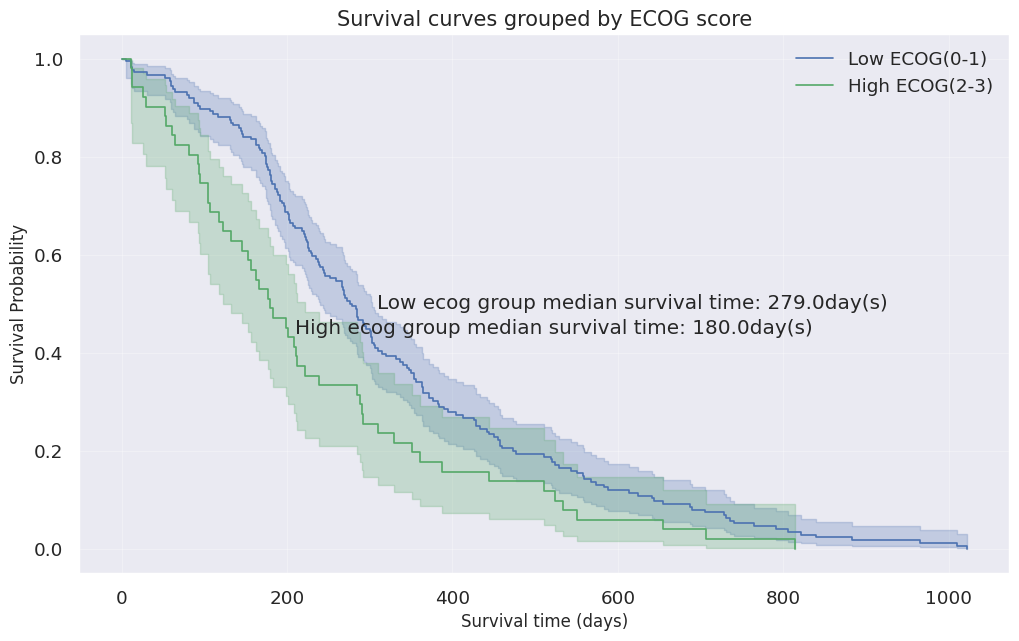

In [ ]:
data['ecog_group'] = np.where(data['ph.ecog'] <= 1, '低分组(0-1)', '高分组(2-3)')

kmf_low = KaplanMeierFitter()
kmf_high = KaplanMeierFitter()

low_ecog = data[data['ph.ecog'] <= 1]
high_ecog = data[data['ph.ecog'] > 1]

kmf_low.fit(low_ecog['time'], low_ecog['status'], label='Low ECOG(0-1)')
kmf_high.fit(high_ecog['time'], high_ecog['status'], label='High ECOG(2-3)')

plt.figure(figsize=(12,7))
ax = kmf_low.plot_survival_function(ci_show=True)
kmf_high.plot_survival_function(ax=ax, ci_show=True)
plt.title("Survival curves grouped by ECOG score", fontsize=15)
plt.xlabel("Survival time (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, alpha=0.3)

# 添加中位生存时间
med_low = kmf_low.median_survival_time_
med_high = kmf_high.median_survival_time_
plt.text(med_low+30, 0.5, f'Low ecog group median survival time: {med_low:.1f}day(s)', verticalalignment='center')
plt.text(med_high+30, 0.45, f'High ecog group median survival time: {med_high:.1f}day(s)', verticalalignment='center')
plt.legend()
plt.show()

In [ ]:
results_ecog = logrank_test(low_ecog['time'], high_ecog['time'],
                           event_observed_A=low_ecog['status'],
                           event_observed_B=high_ecog['status'])
print("\nLog-rank检验结果 (ECOG评分):")
print(f"检验统计量: {results_ecog.test_statistic:.3f}")
print(f"p值: {results_ecog.p_value:.4f}")
print(f"结论: {'ECOG评分组间生存差异显著' if results_ecog.p_value < 0.05 else 'ECOG评分组间生存差异不显著'}")


Log-rank检验结果 (ECOG评分):
检验统计量: 8.838
p值: 0.0029
结论: ECOG评分组间生存差异显著


In [ ]:
data['sex_numeric'] = data['sex'] - 1  # 转换为0/1编码
cph = CoxPHFitter()
cph.fit(data[['time', 'status', 'sex_numeric', 'age', 'ph.ecog']],
        duration_col='time',
        event_col='status')

# 输出结果
print("\nCox比例风险模型结果:")
print(cph.summary)


Cox比例风险模型结果:
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
sex_numeric -0.219707   0.802754  0.136621       -0.487480        0.048066   
age          0.000549   1.000549  0.007763       -0.014666        0.015764   
ph.ecog      0.296995   1.345809  0.098637        0.103669        0.490321   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
sex_numeric             0.614172             1.049240     0.0 -1.608144   
age                     0.985441             1.015889     0.0  0.070733   
ph.ecog                 1.109234             1.632840     0.0  3.010978   

                    p  -log2(p)  
covariate                        
sex_numeric  0.107804  3.213522  
age          0.943611  0.083736  
ph.ecog      0.002604  8.585014  


In [ ]:
data['sex_numeric'] = data['sex'] - 1  # 转换为0/1编码
cph = CoxPHFitter()
cph.fit(data[['time', 'status', 'sex_numeric',  'ph.ecog']],
        duration_col='time',
        event_col='status')

# 输出结果
print("\nCox比例风险模型结果:")
print(cph.summary)


Cox比例风险模型结果:
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
sex_numeric -0.220004   0.802516  0.136549       -0.487636        0.047628   
ph.ecog      0.298402   1.347703  0.096631        0.109008        0.487795   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
sex_numeric             0.614077             1.048780     0.0 -1.611169   
ph.ecog                 1.115171             1.628721     0.0  3.088047   

                    p  -log2(p)  
covariate                        
sex_numeric  0.107143  3.222393  
ph.ecog      0.002015  8.955171  


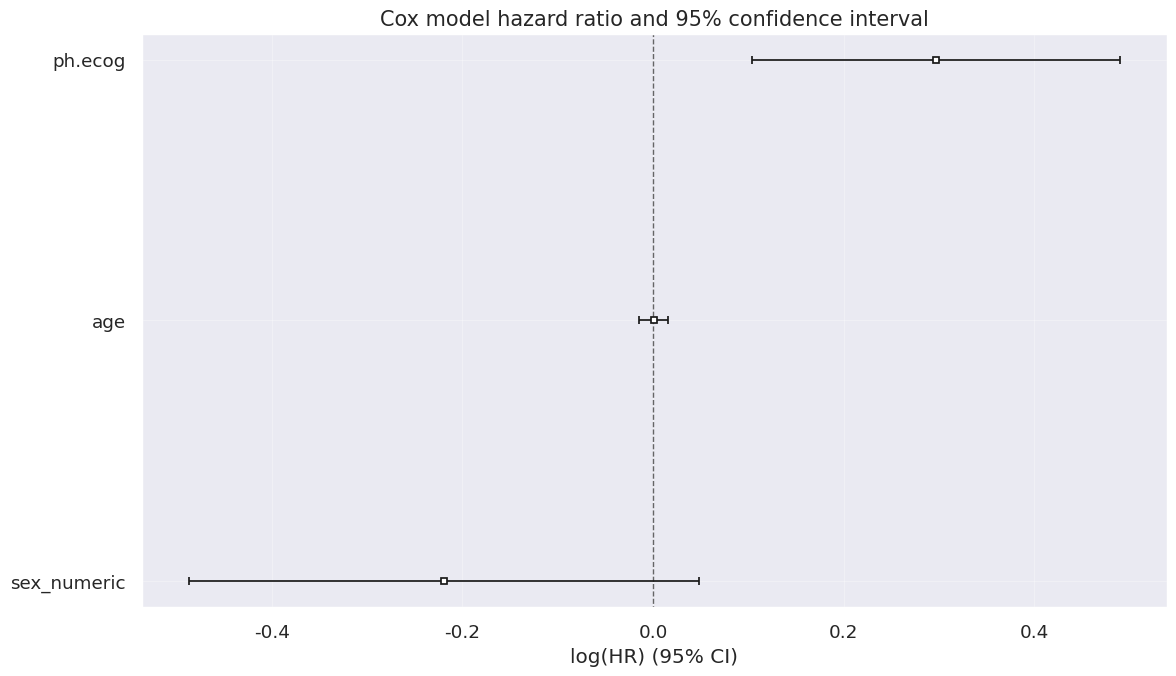

In [ ]:
# 创建Cox模型


# 可视化风险比及其置信区间
plt.figure(figsize=(12,7))
cph.plot()
plt.title("Cox model hazard ratio and 95% confidence interval", fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


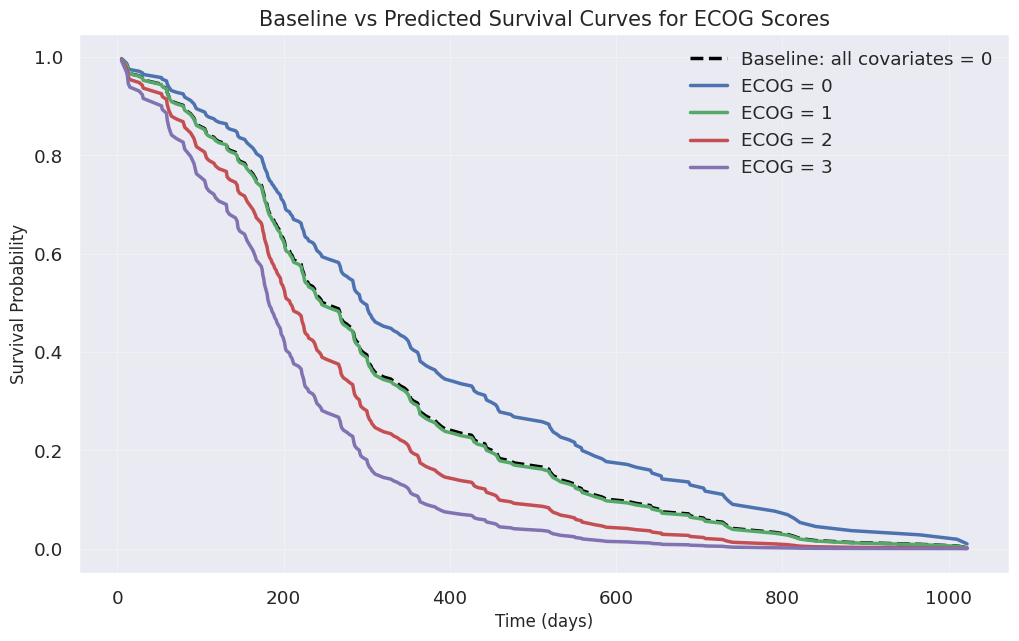

In [ ]:
# Step 1: 提取 baseline survival function（所有协变量为 0）
baseline_survival = cph.baseline_survival_

# Step 2: 构造 ECOG = 0,1,2,3 的预测数据（其余协变量取均值）
mean_sex = data['sex_numeric'].mean()
mean_age = data['age'].mean()
ecog_values = [0, 1, 2, 3]

prediction_data = pd.DataFrame({
    'sex_numeric': [mean_sex] * 4,
    'age': [mean_age] * 4,
    'ph.ecog': ecog_values
})

# Step 3: 计算生存函数
survival_functions = cph.predict_survival_function(prediction_data)

# Step 4: 绘图
fig, ax = plt.subplots(figsize=(12, 7))

# 基线生存曲线
plt.plot(baseline_survival.index, baseline_survival.values,
         label='Baseline: all covariates = 0', linestyle='--', color='black',linewidth=2.5)

# ECOG 预测曲线
#colors = ['green', 'blue', 'orange', 'red']
for i, ecog in enumerate(ecog_values):
    plt.plot(survival_functions.index, survival_functions.iloc[:, i],
             label=f'ECOG = {ecog}',linewidth=2.5
             #, color=colors[i]
             )

plt.title("Baseline vs Predicted Survival Curves for ECOG Scores", fontsize=15)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


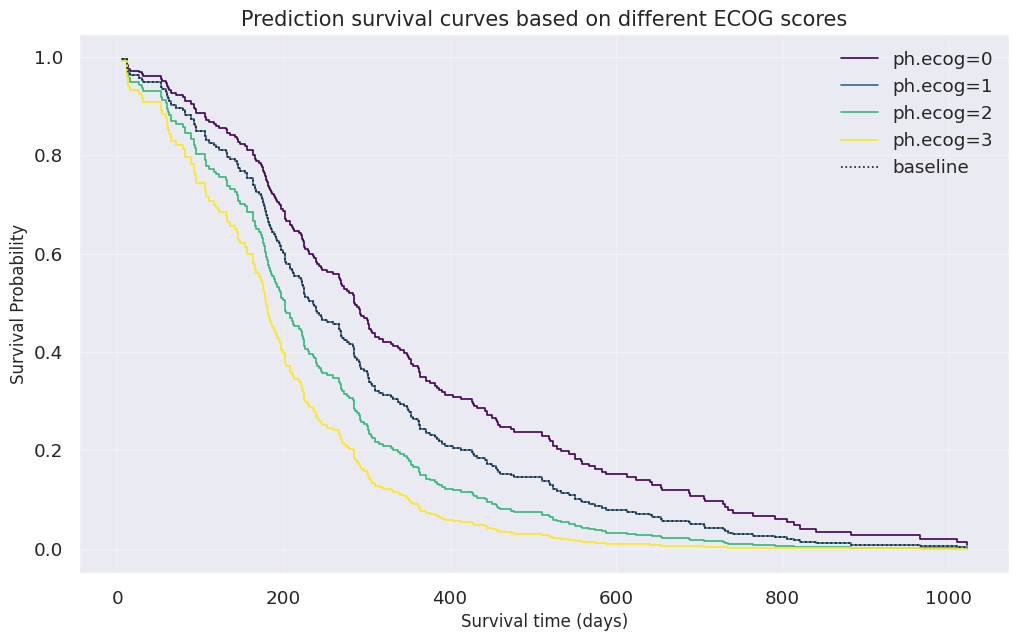

In [ ]:
# 创建Cox模型

# 按ECOG评分绘制预测生存曲线
fig, ax = plt.subplots(figsize=(12, 7))

# 创建预测数据，不同ECOG评分，其他变量取均值
prediction_data = pd.DataFrame({
    'sex_numeric': [0.5] * 4,  # 使用平均值
    'age': [data['age'].mean()] * 4,
    'ph.ecog': [0, 1, 2, 3]
})

# 绘制预测生存曲线
cph.plot_partial_effects_on_outcome('ph.ecog', values=[0, 1, 2, 3],
                                   cmap='viridis', ax=ax)
plt.title("Prediction survival curves based on different ECOG scores", fontsize=15)
plt.xlabel("Survival time (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()



In [ ]:
# 检查比例风险假设


ValueError: shapes (228,2) and (3,) not aligned: 2 (dim 1) != 3 (dim 0)

<Figure size 1200x700 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import shapiro, normaltest, anderson, ks_2samp, mannwhitneyu
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

# 设置绘图样式
plt.style.use('seaborn-v0_8')
sns.set_context("paper", font_scale=1.5)

# 定义数据获取函数
def get_stock_data(tickers, start_date, end_date):
    """获取股票价格数据并计算日收益率"""
    df = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    returns = df.pct_change().dropna()
    return df, returns



In [ ]:
import yfinance as yf
import pandas as pd

def get_stock_data(tickers, start_date, end_date):
    all_close = pd.DataFrame()

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date, end=end_date)
            if 'Close' in hist.columns:
                all_close[ticker] = hist['Close']
            else:
                print(f"{ticker} 的数据中不包含 'Close' 列。")
        except Exception as e:
            print(f"获取 {ticker} 数据时出错: {e}")

    returns = all_close.pct_change().dropna()
    return all_close, returns

# 示例
tickers = ['^GSPC', 'XLF', 'XLK', 'XLV', 'XLE']
start_date = '2010-01-01'
end_date = '2023-01-01'

prices, returns = get_stock_data(tickers, start_date, end_date)

print(prices.head())
print(returns.head())




                                 ^GSPC       XLF        XLK        XLV  \
Date                                                                     
2010-01-04 00:00:00-05:00  1132.989990  9.080477  18.864763  24.412601   
2010-01-05 00:00:00-05:00  1136.520020  9.247378  18.840443  24.173191   
2010-01-06 00:00:00-05:00  1137.140015  9.265917  18.629665  24.420330   
2010-01-07 00:00:00-05:00  1141.689941  9.463726  18.556698  24.505278   
2010-01-08 00:00:00-05:00  1144.979980  9.408092  18.678303  24.543890   

                                 XLE  
Date                                  
2010-01-04 00:00:00-05:00  35.645317  
2010-01-05 00:00:00-05:00  35.936249  
2010-01-06 00:00:00-05:00  36.366581  
2010-01-07 00:00:00-05:00  36.312027  
2010-01-08 00:00:00-05:00  36.548420  
                              ^GSPC       XLF       XLK       XLV       XLE
Date                                                                       
2010-01-05 00:00:00-05:00  0.003116  0.018380 -0.001289 

In [ ]:
import yfinance as yf

ticker = yf.Ticker("^VIX")
vix_data = ticker.history(start=start_date, end=end_date)
vix = vix_data['Close']


In [ ]:
# 查看数据基本信息
print(f"数据时间范围: {prices.index.min()} 至 {prices.index.max()}")
print(f"数据集维度: {returns.shape}")
print("\n收益率数据前5行:")
print(returns.head())


数据时间范围: 2010-01-04 00:00:00-05:00 至 2022-12-30 00:00:00-05:00
数据集维度: (3271, 5)

收益率数据前5行:
                              ^GSPC       XLF       XLK       XLV       XLE
Date                                                                       
2010-01-05 00:00:00-05:00  0.003116  0.018380 -0.001289 -0.009807  0.008162
2010-01-06 00:00:00-05:00  0.000546  0.002005 -0.011187  0.010224  0.011975
2010-01-07 00:00:00-05:00  0.004001  0.021348 -0.003917  0.003479 -0.001500
2010-01-08 00:00:00-05:00  0.002882 -0.005879  0.006553  0.001576  0.006510
2010-01-11 00:00:00-05:00  0.001747  0.000657 -0.003906  0.005664 -0.001327


In [ ]:
# 查看数据基本信息
print(f"数据时间范围: {prices.index.min()} 至 {prices.index.max()}")
print(f"数据集维度: {returns.shape}")
print("\n收益率数据前5行:")
print(returns.head())

数据时间范围: 2010-01-04 00:00:00-05:00 至 2022-12-30 00:00:00-05:00
数据集维度: (3271, 5)

收益率数据前5行:
                              ^GSPC       XLF       XLK       XLV       XLE
Date                                                                       
2010-01-05 00:00:00-05:00  0.003116  0.018380 -0.001289 -0.009807  0.008162
2010-01-06 00:00:00-05:00  0.000546  0.002005 -0.011187  0.010224  0.011975
2010-01-07 00:00:00-05:00  0.004001  0.021348 -0.003917  0.003479 -0.001500
2010-01-08 00:00:00-05:00  0.002882 -0.005879  0.006553  0.001576  0.006510
2010-01-11 00:00:00-05:00  0.001747  0.000657 -0.003906  0.005664 -0.001327


In [ ]:
print("\n缺失值检查:")
print(returns.isnull().sum())


# 基本描述统计
print("\n收益率描述统计:")
stats_df = returns.describe().T
stats_df['kurtosis'] = returns.kurtosis()
stats_df['skewness'] = returns.skew()
print(stats_df)


缺失值检查:
^GSPC    0
XLF      0
XLK      0
XLV      0
XLE      0
dtype: int64

收益率描述统计:
        count      mean       std       min       25%       50%       75%  \
^GSPC  3271.0  0.000436  0.011219 -0.119841 -0.003859  0.000633  0.005639   
XLF    3271.0  0.000499  0.014501 -0.137093 -0.006132  0.000686  0.007685   
XLK    3271.0  0.000663  0.013489 -0.138140 -0.005050  0.000982  0.007159   
XLV    3271.0  0.000569  0.010530 -0.098610 -0.004314  0.000862  0.006123   
XLE    3271.0  0.000412  0.017861 -0.201412 -0.007665  0.000374  0.008755   

            max   kurtosis  skewness  
^GSPC  0.093828  12.275971 -0.491554  
XLF    0.131566  10.990504 -0.220211  
XLK    0.117320   9.793232 -0.225319  
XLV    0.077057   7.573001 -0.276435  
XLE    0.160373  13.032773 -0.394498  


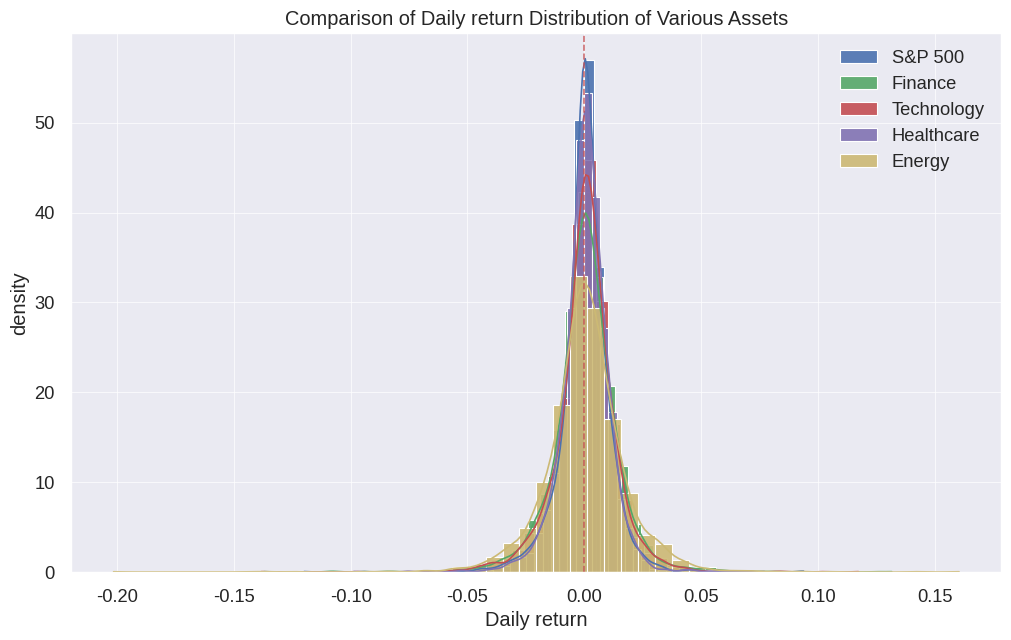

In [ ]:


# 将指数收益率单独提取出来用于后续分析
sp500_returns = returns['^GSPC']

# 绘制收益率直方图与核密度估计
plt.figure(figsize=(12, 7))
for i, ticker in enumerate(returns.columns):
    sns.histplot(returns[ticker], kde=True, stat="density", alpha=0.9,
                 label=names[i], bins=50)

plt.axvline(x=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel("Daily return")
plt.ylabel("density")
plt.title("Comparison of Daily return Distribution of Various Assets")
plt.legend()
plt.grid(True, alpha=0.7)
plt.show()

In [ ]:
print("\n正态性检验结果:")
for i, ticker in enumerate(returns.columns):
    # Shapiro-Wilk检验
    stat_sw, p_sw = shapiro(returns[ticker].dropna())
    # D'Agostino-Pearson检验
    stat_dp, p_dp = normaltest(returns[ticker].dropna())

    print(f"{names[i]}:")
    print(f"  Shapiro-Wilk检验: 统计量={stat_sw:.4f}, p值={p_sw:.10f}")
    print(f"  D'Agostino-Pearson检验: 统计量={stat_dp:.4f}, p值={p_dp:.10f}")
    print(f"  结论: {'拒绝正态分布假设' if p_sw < 0.05 else '未能拒绝正态分布假设'}")


正态性检验结果:
S&P 500:
  Shapiro-Wilk检验: 统计量=0.8925, p值=0.0000000000
  D'Agostino-Pearson检验: 统计量=766.2848, p值=0.0000000000
  结论: 拒绝正态分布假设
Finance:
  Shapiro-Wilk检验: 统计量=0.9068, p值=0.0000000000
  D'Agostino-Pearson检验: 统计量=636.5950, p值=0.0000000000
  结论: 拒绝正态分布假设
Technology:
  Shapiro-Wilk检验: 统计量=0.9151, p值=0.0000000000
  D'Agostino-Pearson检验: 统计量=599.7988, p值=0.0000000000
  结论: 拒绝正态分布假设
Healthcare:
  Shapiro-Wilk检验: 统计量=0.9321, p值=0.0000000000
  D'Agostino-Pearson检验: 统计量=530.3143, p值=0.0000000000
  结论: 拒绝正态分布假设
Energy:
  Shapiro-Wilk检验: 统计量=0.9073, p值=0.0000000000
  D'Agostino-Pearson检验: 统计量=746.7244, p值=0.0000000000
  结论: 拒绝正态分布假设


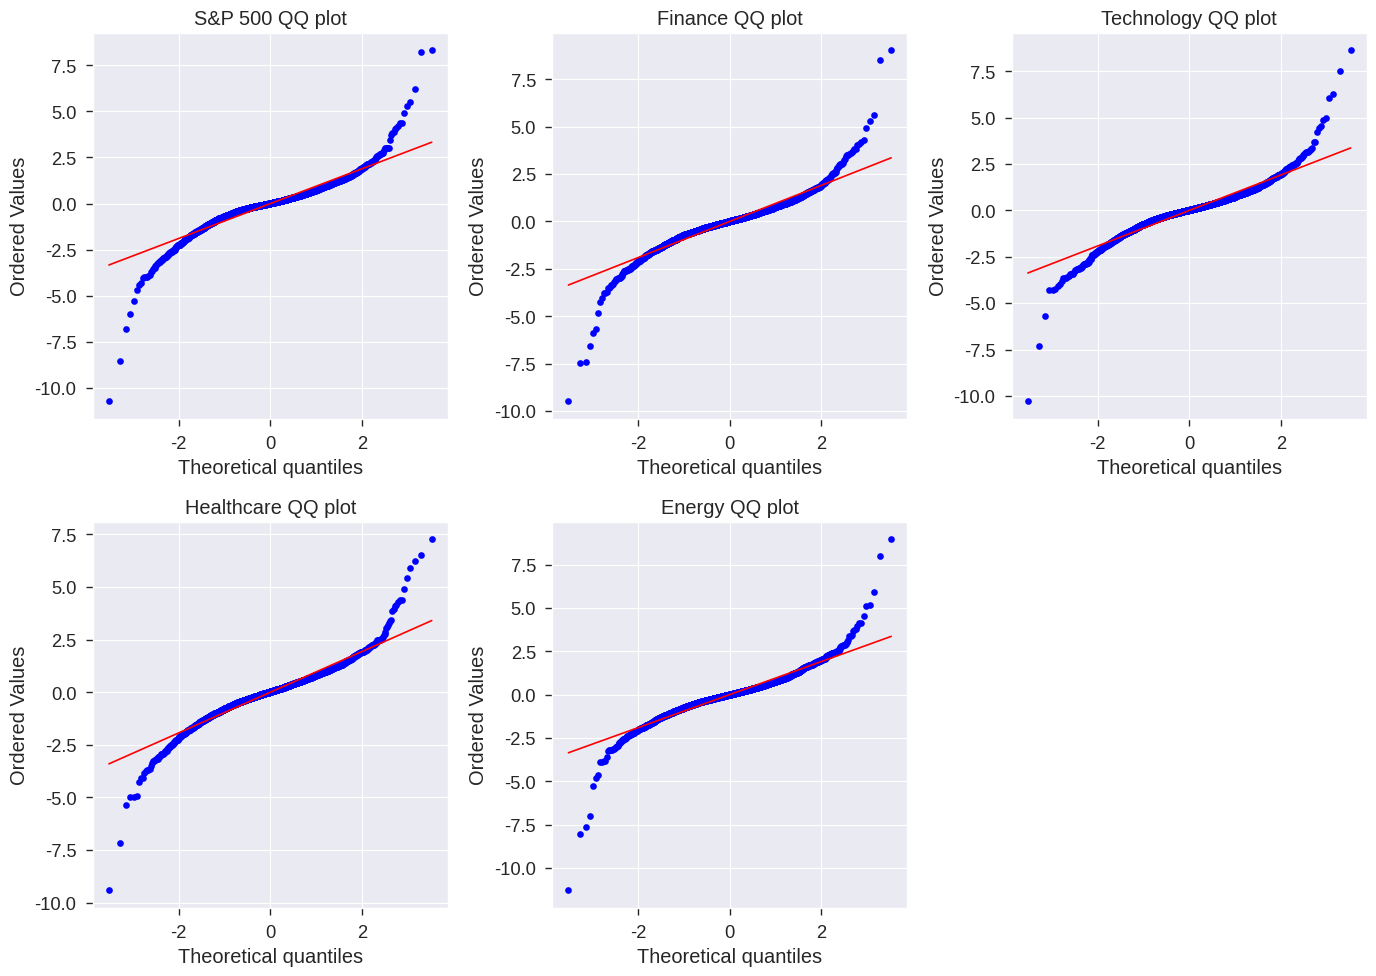

In [ ]:
import scipy.stats as stats

plt.figure(figsize=(14, 10))
for i, ticker in enumerate(returns.columns):
    plt.subplot(2, 3, i+1)

    data = returns[ticker].dropna()
    data_std = (data - data.mean()) / data.std()  # 标准化

    stats.probplot(data_std, dist="norm", plot=plt)
    plt.title(f"{names[i]} QQ plot")

plt.tight_layout()
plt.show()


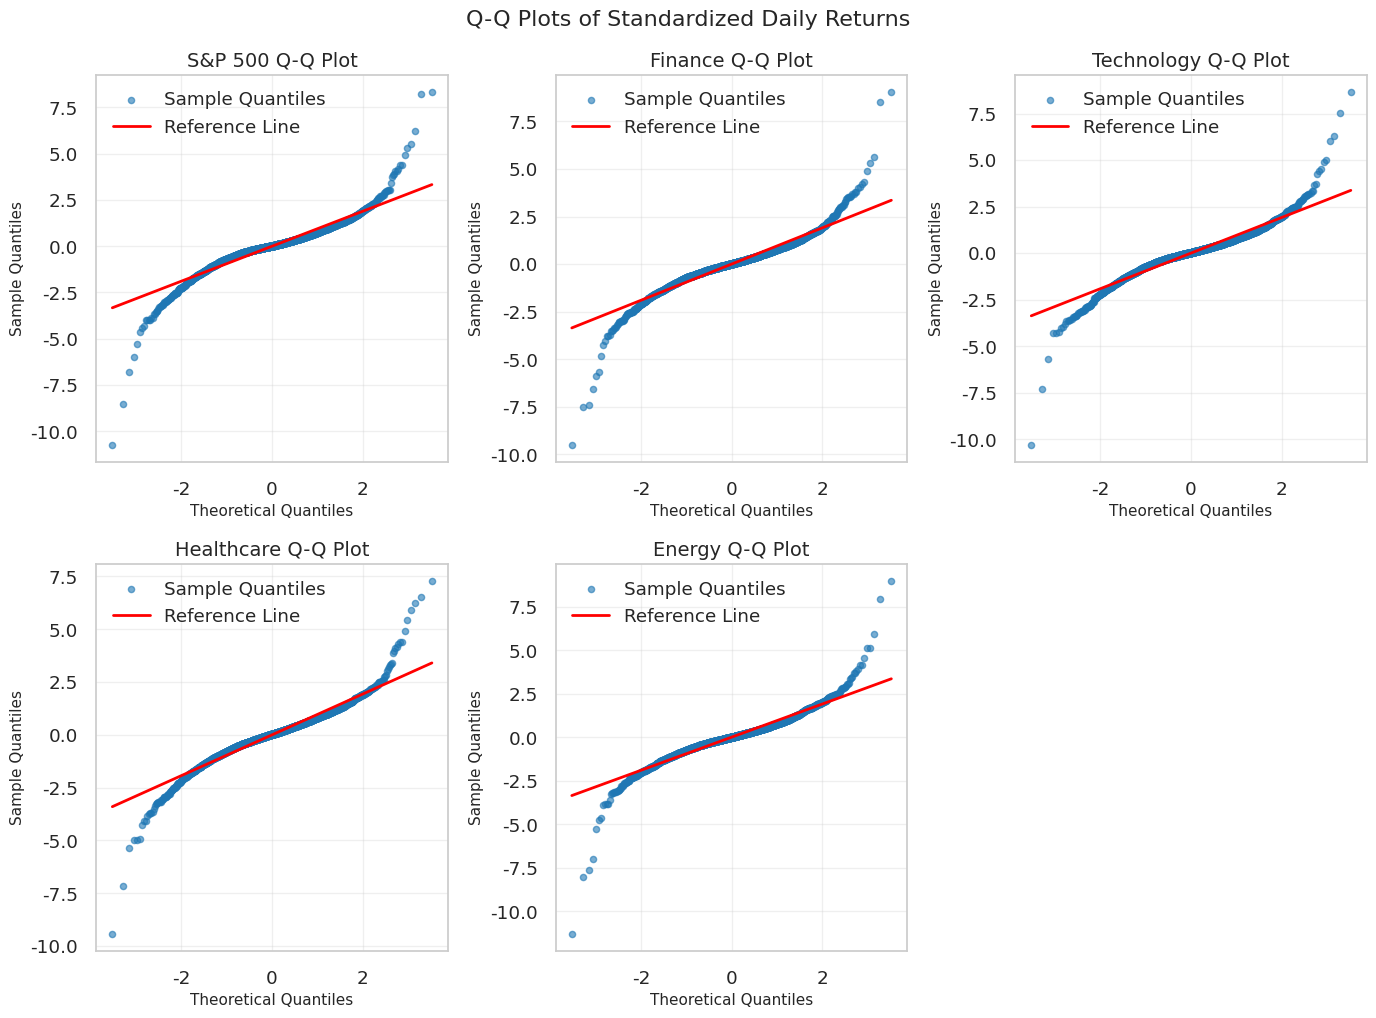

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# 设置 Seaborn 风格
sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(14, 10))

for i, ticker in enumerate(returns.columns):
    plt.subplot(2, 3, i + 1)

    data = returns[ticker].dropna()
    data_std = (data - data.mean()) / data.std()

    # 绘制 Q-Q 图
    (osm, osr), (slope, intercept, r) = stats.probplot(data_std, dist="norm")

    plt.scatter(osm, osr, s=20, color="#1f77b4", alpha=0.6, label="Sample Quantiles")
    plt.plot(osm, slope * osm + intercept, color="red", lw=2, label="Reference Line")

    plt.title(f"{names[i]} Q-Q Plot", fontsize=14)
    plt.xlabel("Theoretical Quantiles", fontsize=11)
    plt.ylabel("Sample Quantiles", fontsize=11)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Q-Q Plots of Standardized Daily Returns", fontsize=16, y=1.02)
plt.show()


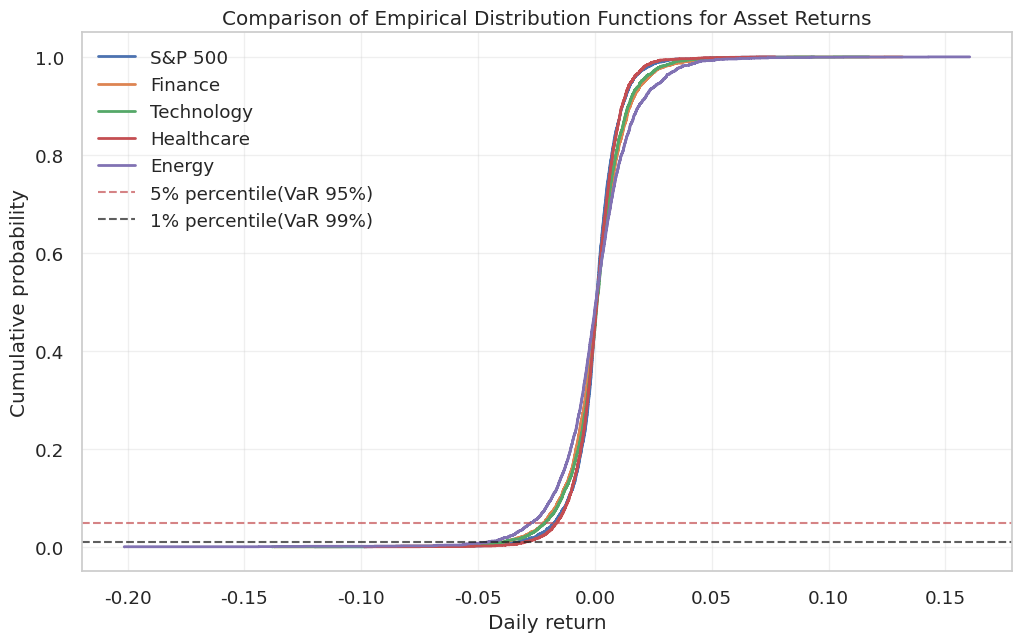

In [ ]:
plt.figure(figsize=(12, 7))
for i, ticker in enumerate(returns.columns):
    ecdf = ECDF(returns[ticker].dropna())
    plt.step(ecdf.x, ecdf.y, linewidth=2, label=names[i])

plt.axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% percentile(VaR 95%)')
plt.axhline(y=0.01, color='k', linestyle='--', alpha=0.7, label='1% percentile(VaR 99%)')
plt.xlabel('Daily return')
plt.ylabel('Cumulative probability')
plt.title('Comparison of Empirical Distribution Functions for Asset Returns')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def calc_risk_metrics(returns, confidence_levels=[0.95, 0.99]):
    """计算非参数VaR和CVaR"""
    results = {}
    for level in confidence_levels:
        var = -np.percentile(returns, 100 * (1 - level))
        cvar = -returns[returns <= -var].mean()
        results[f'VaR_{int(level*100)}'] = var
        results[f'CVaR_{int(level*100)}'] = cvar
    return results

# 展示各资产的风险指标
risk_df = pd.DataFrame()
for i, ticker in enumerate(returns.columns):
    metrics = calc_risk_metrics(returns[ticker].dropna())
    risk_df[names[i]] = pd.Series(metrics)

print("\n非参数风险指标:")
print(risk_df.T)


非参数风险指标:
              VaR_95   CVaR_95    VaR_99   CVaR_99
S&P 500     0.017199  0.027565  0.032409  0.045888
Finance     0.021629  0.033912  0.037991  0.057450
Technology  0.021097  0.032212  0.038835  0.051115
Healthcare  0.016135  0.024729  0.029696  0.039963
Energy      0.026625  0.041074  0.045470  0.069594


In [ ]:
prices_sp500 = prices['^GSPC']
ma200 = prices_sp500.rolling(200).mean()
bull = returns[prices_sp500 > ma200]
bear = returns[prices_sp500 < ma200]

# Mann-Whitney U检验用于比较两组分布
print("\n牛熊市收益率分布非参数检验结果:")
for i, ticker in enumerate(returns.columns):
    stat, p = mannwhitneyu(bull[ticker].dropna(), bear[ticker].dropna(), alternative='two-sided')
    print(f"{names[i]}: 统计量={stat:.2f}, p值={p:.6f}, 结论: {'分布显著不同' if p<0.05 else '未发现显著差异'}")


牛熊市收益率分布非参数检验结果:
S&P 500: 统计量=798348.00, p值=0.000256, 结论: 分布显著不同
Finance: 统计量=805387.50, p值=0.000058, 结论: 分布显著不同
Technology: 统计量=797589.00, p值=0.000298, 结论: 分布显著不同
Healthcare: 统计量=784326.50, p值=0.003384, 结论: 分布显著不同
Energy: 统计量=736164.50, p值=0.662642, 结论: 未发现显著差异


<ipython-input-179-732ca84a1dc2>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bull = returns[prices_sp500 > ma200]
<ipython-input-179-732ca84a1dc2>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bear = returns[prices_sp500 < ma200]


In [ ]:
returns.isnull().sum()

,0
^GSPC,0
XLF,0
XLK,0
XLV,0
XLE,0


In [ ]:
# 根据标普500指数的200日移动平均线定义牛熊市
prices_sp500 = prices['^GSPC']
ma200 = prices_sp500.rolling(window=200).mean()
bull_market = prices_sp500 >= ma200
bear_market = ~bull_market

# 分割收益率数据
bull_returns = returns[bull_market]
bear_returns = returns[bear_market]

print("\n牛市与熊市样本量:")
print(f"牛市交易日: {bull_returns.shape[0]}天")
print(f"熊市交易日: {bear_returns.shape[0]}天")

# Mann-Whitney U检验比较牛熊市场收益率
print("\nMann-Whitney U检验结果:")
for i, ticker in enumerate(returns.columns):
    stat, p = mannwhitneyu(
        bull_returns[ticker].dropna(),
        bear_returns[ticker].dropna(),
        alternative='greater'
    )
    print(f"{names[i]}: U统计量={stat:.2f}, p值={p:.6f}, "
          f"结论: {'牛市收益率显著高于熊市' if p < 0.05 else '无显著差异'}")


牛市与熊市样本量:
牛市交易日: 2488天
熊市交易日: 783天

Mann-Whitney U检验结果:
S&P 500: U统计量=1050452.00, p值=0.000458, 结论: 牛市收益率显著高于熊市
Finance: U统计量=1057614.00, p值=0.000144, 结论: 牛市收益率显著高于熊市
Technology: U统计量=1051161.00, p值=0.000410, 结论: 牛市收益率显著高于熊市
Healthcare: U统计量=1044427.50, p值=0.001131, 结论: 牛市收益率显著高于熊市
Energy: U统计量=987869.50, p值=0.274419, 结论: 无显著差异


<ipython-input-181-2b805aec8236>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bull_returns = returns[bull_market]
<ipython-input-181-2b805aec8236>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bear_returns = returns[bear_market]


In [ ]:
# 计算并比较牛熊市场的风险指标
bull_risk = pd.DataFrame()
bear_risk = pd.DataFrame()

for i, ticker in enumerate(returns.columns):
    bull_metrics = calc_risk_metrics(bull_returns[ticker].dropna())
    bear_metrics = calc_risk_metrics(bear_returns[ticker].dropna())
    bull_risk[names[i]] = pd.Series(bull_metrics)
    bear_risk[names[i]] = pd.Series(bear_metrics)

print("\n牛市风险指标:")
print(bull_risk.T)
print("\n熊市风险指标:")
print(bear_risk.T)



牛市风险指标:
              VaR_95   CVaR_95    VaR_99   CVaR_99
S&P 500     0.012219  0.018522  0.022733  0.028381
Finance     0.016161  0.022879  0.027071  0.034021
Technology  0.016057  0.023592  0.027282  0.035562
Healthcare  0.012592  0.018334  0.021668  0.027549
Energy      0.021162  0.030501  0.036662  0.043661

熊市风险指标:
              VaR_95   CVaR_95    VaR_99   CVaR_99
S&P 500     0.029081  0.042354  0.045175  0.070628
Finance     0.035862  0.052849  0.058690  0.093021
Technology  0.034688  0.047068  0.048969  0.072851
Healthcare  0.025478  0.036532  0.040266  0.058597
Energy      0.038386  0.062914  0.068642  0.117094


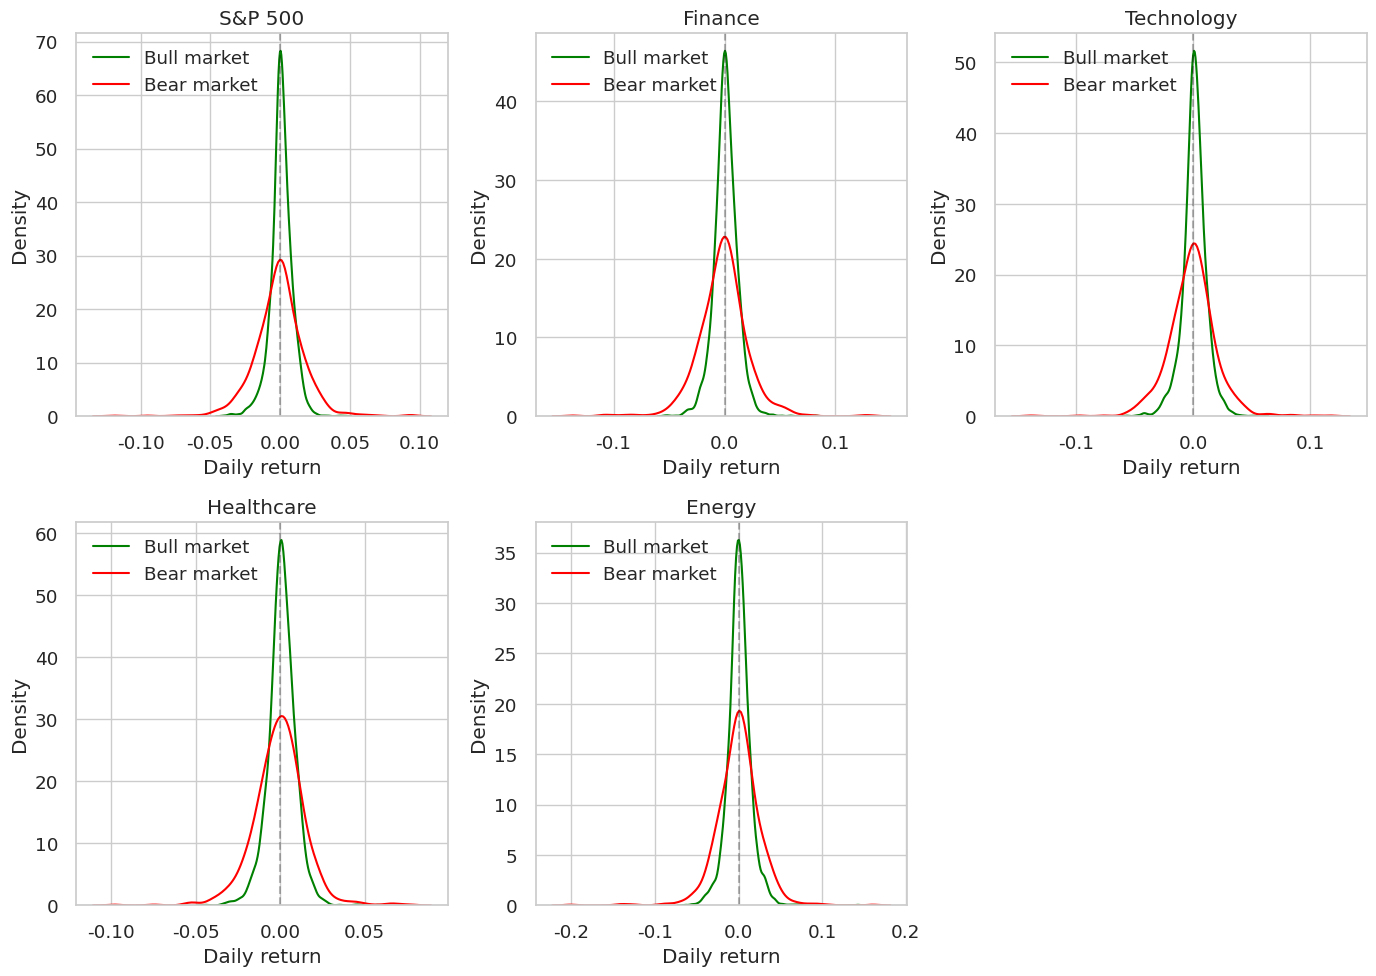

In [ ]:
# 绘制牛熊市场核密度估计对比
plt.figure(figsize=(14, 10))
for i, ticker in enumerate(returns.columns):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(bull_returns[ticker].dropna(), label='Bull market', color='green')
    sns.kdeplot(bear_returns[ticker].dropna(), label='Bear market', color='red')
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.title(f"{names[i]}")
    plt.xlabel('Daily return')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.formula.api as smf
returns = returns.rename(columns={'^GSPC': 'GSPC'})
print("分位数回归结果（XLF ~ GSPC）：")
for q in [0.1, 0.25, 0.5, 0.75, 0.9]:
    res = smf.quantreg('XLF ~ GSPC', returns.dropna()).fit(q=q)
    print(f"{int(q*100)}%分位数: alpha={res.params['Intercept']:.4f}, beta={res.params['GSPC']:.4f}")

分位数回归结果（XLF ~ GSPC）：
10%分位数: alpha=-0.0074, beta=1.1341
25%分位数: alpha=-0.0035, beta=1.1151
50%分位数: alpha=-0.0002, beta=1.1231
75%分位数: alpha=0.0033, beta=1.1326
90%分位数: alpha=0.0076, beta=1.1367


In [ ]:
# 仅使用ETF数据进行投资组合优化
etf_returns = returns.iloc[:, 1:].dropna()

# 定义CVaR函数
def portfolio_cvar(weights, returns, alpha=0.05):
    portfolio_returns = returns.dot(weights)
    var = -np.percentile(portfolio_returns, alpha * 100)
    cvar = -portfolio_returns[portfolio_returns <= -var].mean()
    return cvar

# 优化目标函数
def objective(weights, returns, alpha=0.05):
    portfolio_mean = returns.mean().dot(weights) * 252
    portfolio_risk = portfolio_cvar(weights, returns, alpha)
    return -portfolio_mean / portfolio_risk

# 优化设置
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(etf_returns.shape[1]))
initial_weights = np.ones(etf_returns.shape[1]) / etf_returns.shape[1]

# 求解最优权重
result = minimize(objective, initial_weights, args=(etf_returns, 0.05),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result['x']
print("\n最优投资组合权重:")
for i, w in enumerate(optimal_weights):
    print(f"{names[i+1]}: {w:.4f}")

# 组合表现
portfolio_returns = etf_returns.dot(optimal_weights)
metrics = calc_risk_metrics(portfolio_returns)
metrics['年化收益率'] = portfolio_returns.mean() * 252
metrics['年化波动率'] = portfolio_returns.std() * np.sqrt(252)
metrics['夏普比率'] = metrics['年化收益率'] / metrics['年化波动率']


最优投资组合权重:
Finance: 0.0000
Technology: 0.2264
Healthcare: 0.7736
Energy: 0.0000


In [ ]:
def bootstrap_portfolio(returns, weights, n_samples=1000):
    portfolio_returns = returns.dot(weights)
    n = len(portfolio_returns)

    annual_returns, annual_volatility, sharpe_ratios = [], [], []
    var95, cvar95 = [], []

    for _ in range(n_samples):
        indices = np.random.choice(n, size=n, replace=True)
        sample_returns = portfolio_returns.iloc[indices]
        annual_ret = sample_returns.mean() * 252
        annual_vol = sample_returns.std() * np.sqrt(252)
        sharpe = annual_ret / annual_vol if annual_vol > 0 else 0
        risk_metrics = calc_risk_metrics(sample_returns)

        annual_returns.append(annual_ret)
        annual_volatility.append(annual_vol)
        sharpe_ratios.append(sharpe)
        var95.append(risk_metrics['VaR_95'])
        cvar95.append(risk_metrics['CVaR_95'])

    return {
        'Annualized return': annual_returns,
        'Annualized volatility': annual_volatility,
        'Sharpe ratio': sharpe_ratios,
        'VaR_95': var95,
        'CVaR_95': cvar95
    }

# 执行并绘图
bootstrap_results = bootstrap_portfolio(etf_returns, optimal_weights)

In [ ]:
df_bootstrap = pd.DataFrame(bootstrap_results)

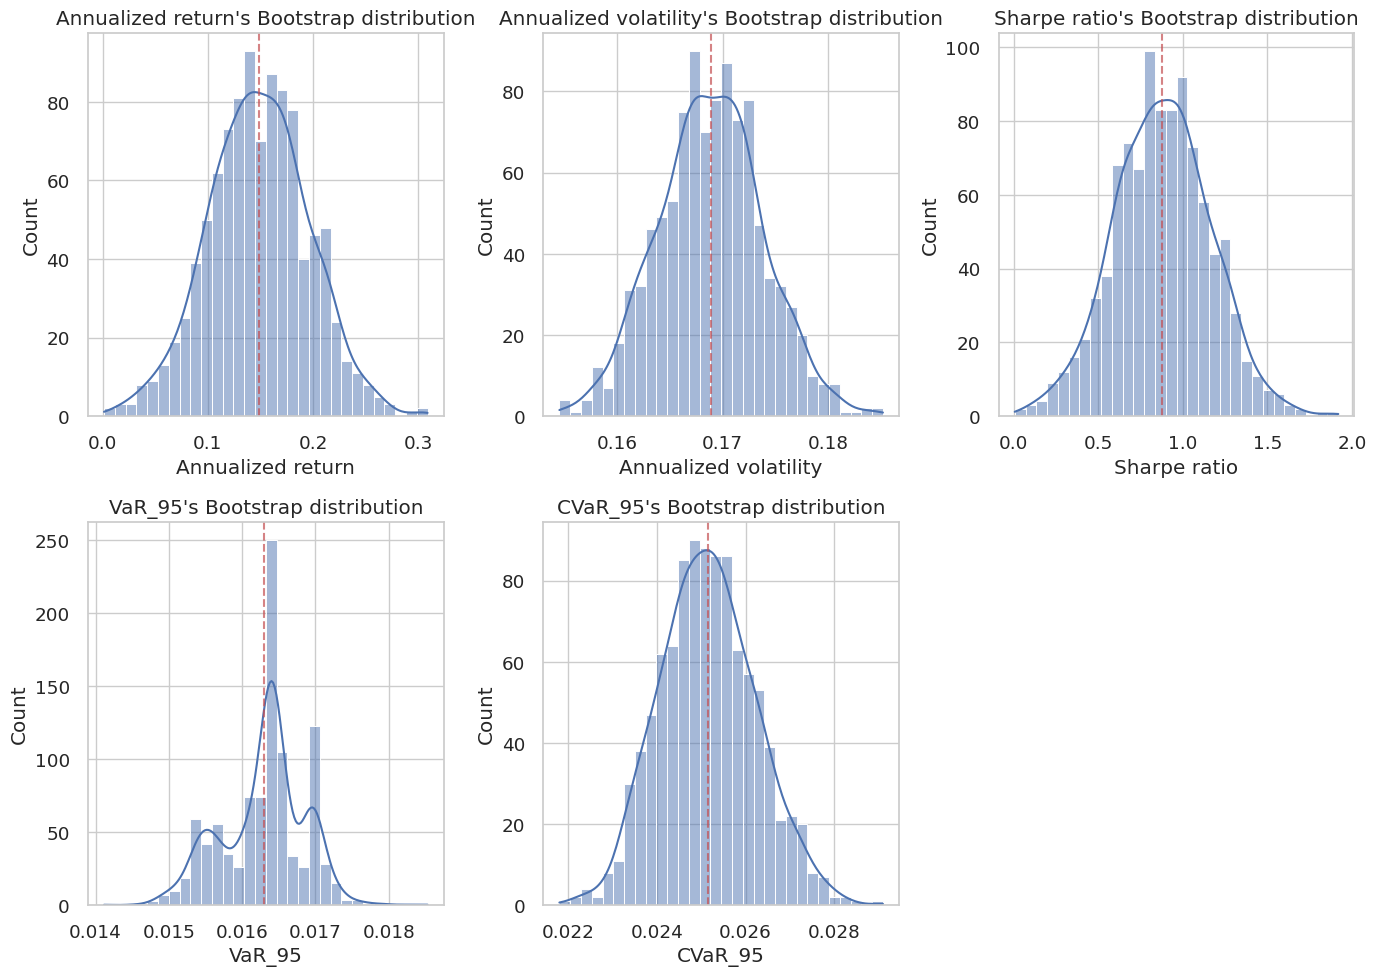


Bootstrap 95% confidence interval
Annualized return: [0.0529, 0.2440]
Annualized volatility: [0.1593, 0.1782]
Sharpe ratio: [0.3106, 1.4293]
VaR_95: [0.0152, 0.0172]
CVaR_95: [0.0232, 0.0273]


In [ ]:
bootstrap_results = bootstrap_portfolio(etf_returns, optimal_weights)

# 绘制Bootstrap结果分布
plt.figure(figsize=(14, 10))
metrics = ['Annualized return', 'Annualized volatility', 'Sharpe ratio', 'VaR_95', 'CVaR_95']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.histplot(bootstrap_results[metric], kde=True, bins=30)
    plt.axvline(np.mean(bootstrap_results[metric]), color='r',
                linestyle='--', alpha=0.7)
    plt.xlabel(metric)
    plt.title(f'{metric}\'s Bootstrap distribution')

plt.tight_layout()
plt.show()

# 输出Bootstrap置信区间
print("\nBootstrap 95% confidence interval")
for metric in metrics:
    lower = np.percentile(bootstrap_results[metric], 2.5)
    upper = np.percentile(bootstrap_results[metric], 97.5)
    print(f"{metric}: [{lower:.4f}, {upper:.4f}]")

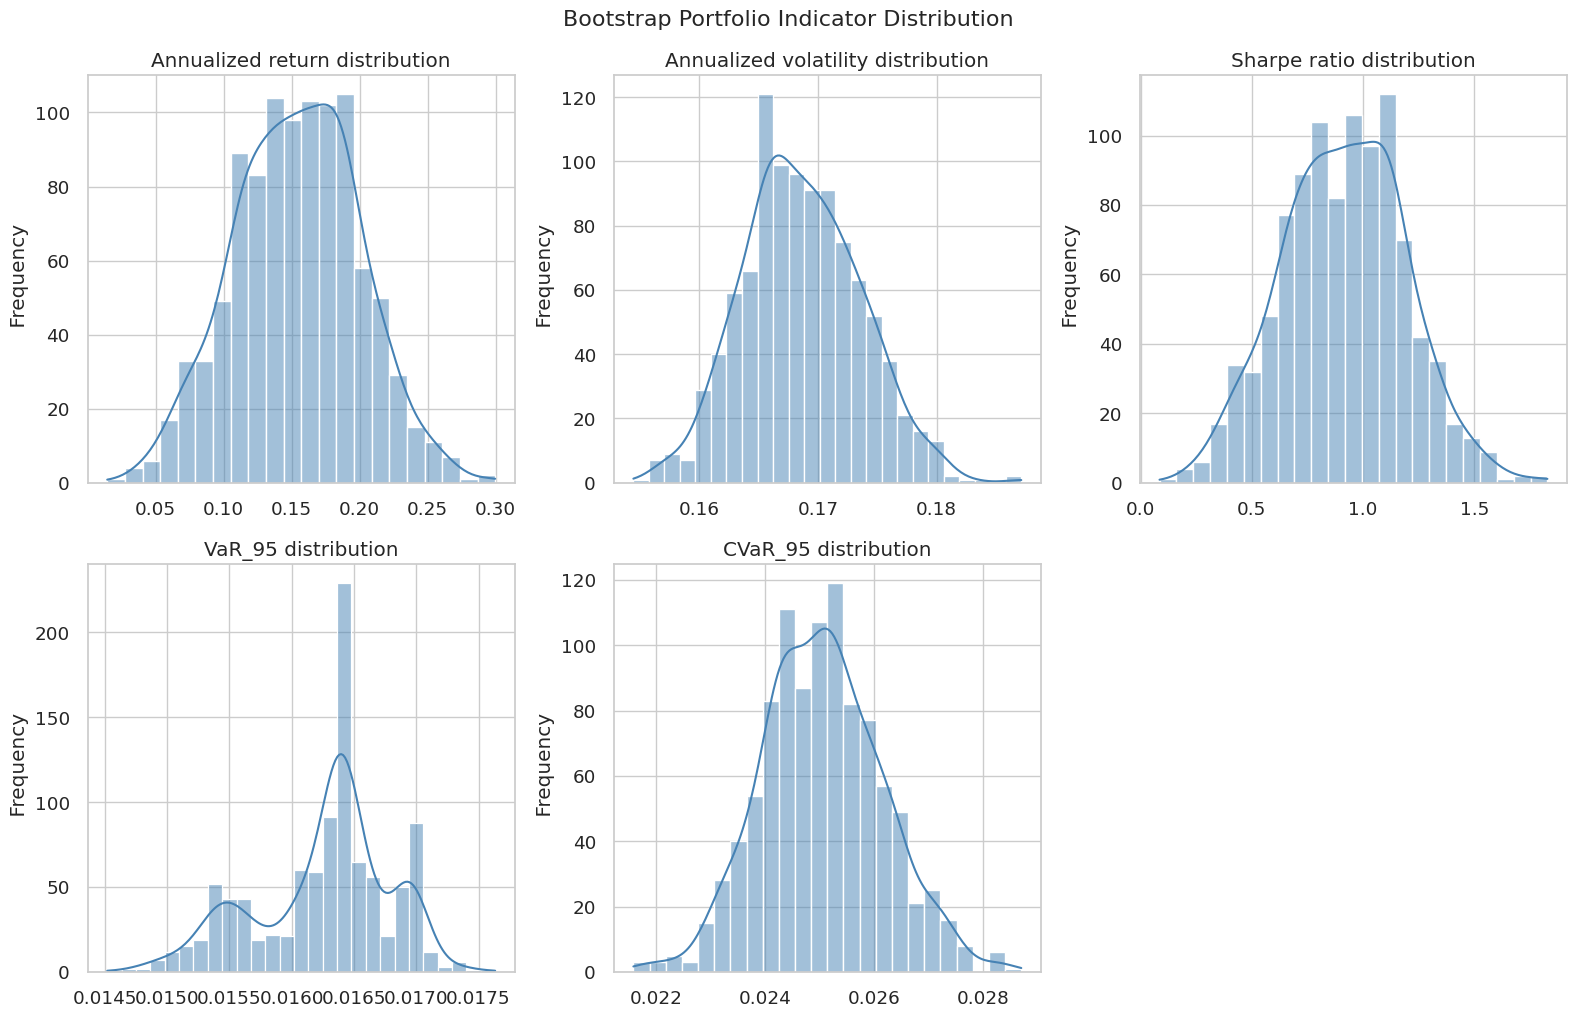

In [ ]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(df_bootstrap.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_bootstrap[col], kde=True, color='steelblue', edgecolor='white')
    plt.title(f"{col} distribution")
    plt.xlabel('')
    plt.ylabel(' Frequency')

plt.tight_layout()
plt.suptitle("Bootstrap Portfolio Indicator Distribution", fontsize=16, y=1.02)
plt.show()


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 228 total observations, 0 right-censored observations>
         test_name = proportional_hazard_test

---
                  test_statistic    p  -log2(p)
age         km              0.76 0.38      1.39
            rank            0.77 0.38      1.39
ph.ecog     km              4.56 0.03      4.93
            rank            4.55 0.03      4.93
sex_numeric km              5.63 0.02      5.82
            rank            5.61 0.02      5.81



1. Variable 'sex_numeric' failed the non-proportional test: p-value is 0.0177.

   Advice: with so few unique values (only 2), you can include `strata=['sex_numeric', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'ph.ecog' failed the non-proportional test: p-value is 0.0328.

   Advice 1: the functional form of the variable 'ph.ecog' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ph.ecog' using pd.cut, and then specify it in
`strata=['ph.ecog', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https:/

[[<Axes: xlabel='rank-transformed time\n(p=0.0178)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0177)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3817)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3823)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0328)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0328)'>]]

<Figure size 1200x700 with 0 Axes>

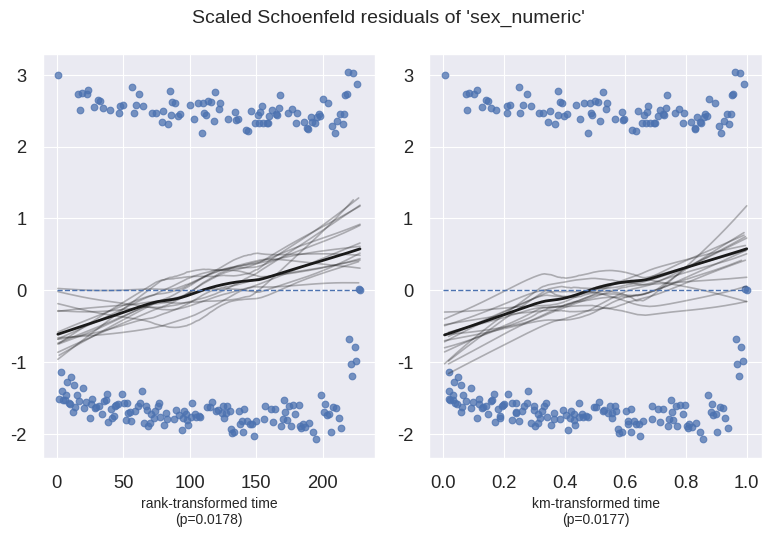

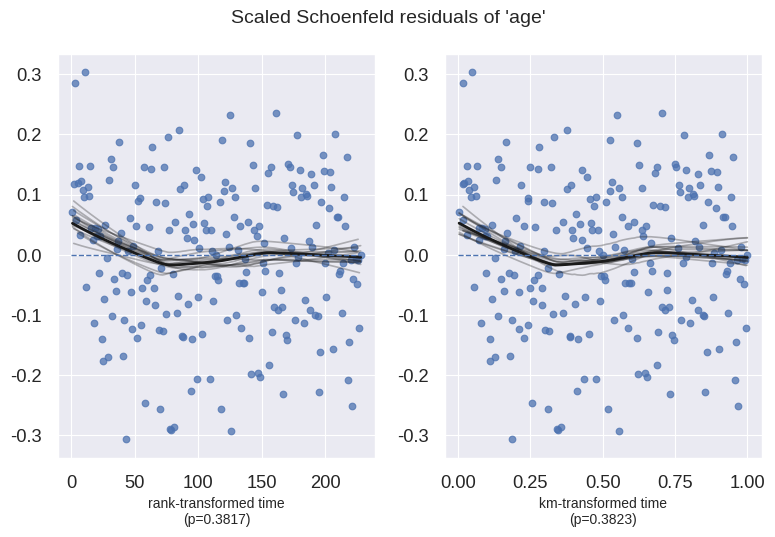

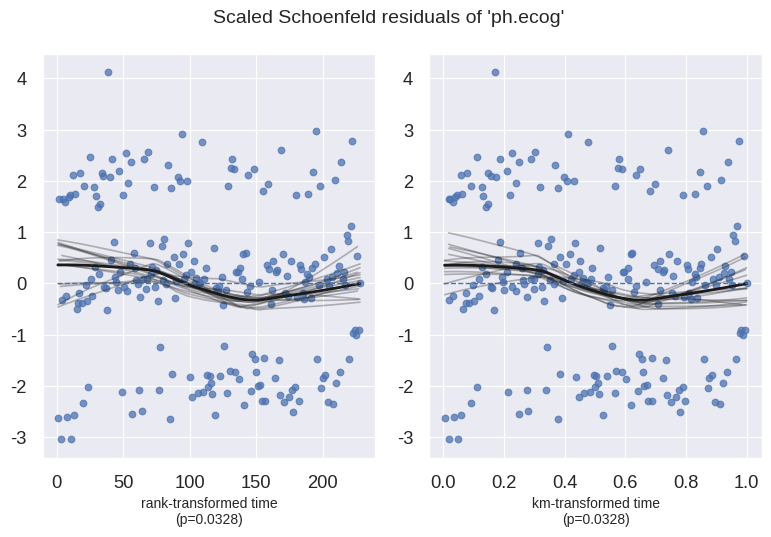

In [ ]:
plt.figure(figsize=(12, 7))
cph.check_assumptions(data[['time', 'status', 'sex_numeric', 'age', 'ph.ecog']], p_value_threshold=0.05, show_plots=True)


In [ ]:
# 创建一个市场风险指标 - VIX指数(波动率指数)
ticker = yf.Ticker("^VIX")
vix_data = ticker.history(start=start_date, end=end_date)
vix = vix_data['Close']
returns1 = returns.tz_convert('UTC')
vix1 = vix.tz_convert('UTC')
vix1 = vix1.reindex(returns.index, method='ffill')
# 将数据合并
analysis_df = pd.DataFrame({
    'sp500_return': returns1['^GSPC'],
    'vix': vix1
}).dropna()

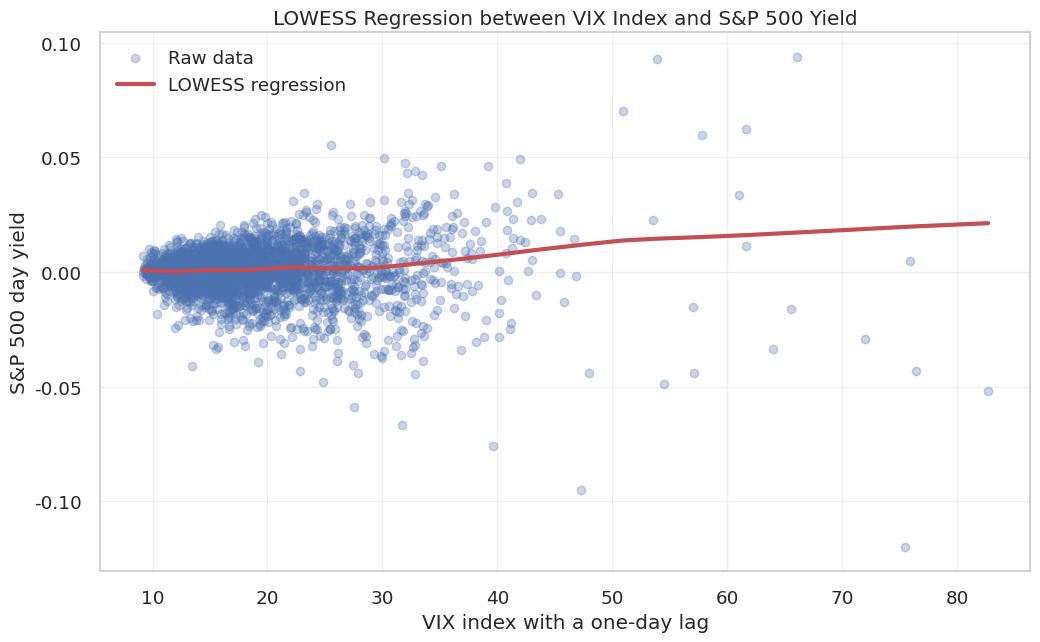

In [ ]:
# 添加滞后项作为预测变量
analysis_df['vix_lag1'] = analysis_df['vix'].shift(1)
analysis_df['return_lag1'] = analysis_df['sp500_return'].shift(1)

# LOWESS回归分析
lowess_result = lowess(
    analysis_df['sp500_return'],
    analysis_df['vix'],
    frac=0.3
)

plt.figure(figsize=(12, 7))
plt.scatter(analysis_df['vix_lag1'], analysis_df['sp500_return'],
            alpha=0.3, label='Raw data')
plt.plot(lowess_result[:, 0], lowess_result[:, 1], 'r-',
         linewidth=3, label='LOWESS regression')
plt.xlabel('VIX index with a one-day lag')
plt.ylabel('S&P 500 day yield')
plt.title('LOWESS Regression between VIX Index and S&P 500 Yield')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
len(y)

3270

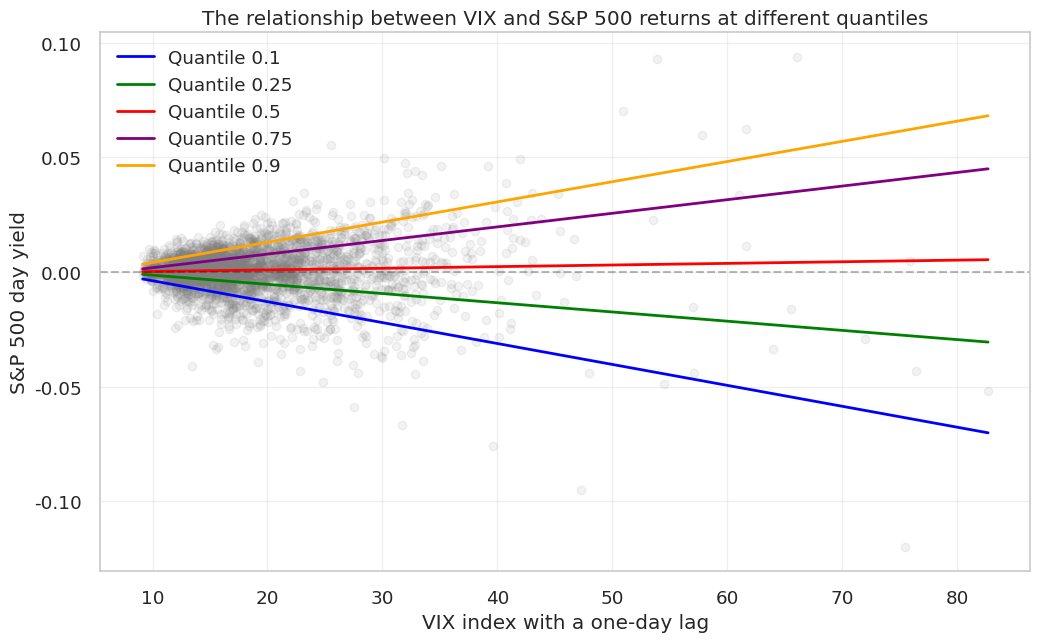


分位数回归结果:

分位数 0.1:
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0053      0.001      6.080      0.000       0.004       0.007
vix_lag1       -0.0009    4.3e-05    -21.226      0.000      -0.001      -0.001
return_lag1     0.1268      0.030      4.207      0.000       0.068       0.186

分位数 0.25:
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0027      0.000      5.374      0.000       0.002       0.004
vix_lag1       -0.0004   2.47e-05    -16.244      0.000      -0.000      -0.000
return_lag1     0.0362      0.015      2.359      0.018       0.006       0.066

分位数 0.5:
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [ ]:
# 分位数回归 - 分析不同分位数下的风险-收益关系
from statsmodels.regression.quantile_regression import QuantReg

# 准备数据
X = analysis_df[['vix_lag1', 'return_lag1']].iloc[1:]
X = sm.add_constant(X)
y = analysis_df['sp500_return']

# 拟合不同分位数的模型
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
models = []

plt.figure(figsize=(12, 7))
colors = ['blue', 'green', 'red', 'purple', 'orange']

# 绘制散点图
plt.scatter(analysis_df['vix_lag1'], y, alpha=0.1, color='gray')

# 对每个分位数拟合模型并绘制
for i, q in enumerate(quantiles):
    model = QuantReg(y[1:], X)
    result = model.fit(q=q)
    models.append(result)

    # 生成预测值用于绘图
    x_range = np.linspace(analysis_df['vix_lag1'].min(), analysis_df['vix_lag1'].max(), 100)
    X_pred = pd.DataFrame({
        'const': 1,
        'vix_lag1': x_range,
        'return_lag1': analysis_df['return_lag1'].median()  # 固定为中位数
    })
    y_pred = result.predict(X_pred)

    plt.plot(x_range, y_pred, color=colors[i],
             label=f'Quantile {q}', linewidth=2)

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('VIX index with a one-day lag')
plt.ylabel('S&P 500 day yield')
plt.title('The relationship between VIX and S&P 500 returns at different quantiles')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 输出各分位数回归系数
print("\n分位数回归结果:")
for i, q in enumerate(quantiles):
    print(f"\n分位数 {q}:")
    print(models[i].summary().tables[1])